**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


__Test Cases:__

1. Try ideal scenario: KW = Identity matrix, A = 0, B = 0
2. Limit number of neurons to 2
3. Test SGD against simple cost function ($y = x^2$)
4. Ideal scenario with A/B: KW = I, A - Kb = 0

In [1]:
import numpy as np
from numpy import linalg, matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# brainFiringRate(lambda_vect, targ_vect) = b + Wt
#********


###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1  
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N
    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new

#********
# Passed test:
# lambda_vect = np.array([[1, 2, 3], [4, 5, 6], [7,8,9], [10, 11, 12]])
# targ_vect = np.array([1, 2])
# gamma = 0.5
# delta_perturb = np.array([[4], [5], [6], [7]])
# calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect) = lambda_vect - (gamma*error grad*[1 tx ty])
#********

### Decoder Model

In [3]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, brain_params):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    (fr_curr, targ) = brain_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = np.zeros( (NUM_DIM, 1))
    cursor_pos = a_vect.reshape(NUM_DIM, 1) +  (np.matmul(k_matx, fr_curr))
    return (cursor_pos)

#********
# Passed Test: 
# a = np.array([-10, -20])
# k = np.random.random([2, 4])
# NUM_DIM = 2
# fr = brainFiringRate(lambda_vect, targ_vect)
# decoder_params = (a, k)
# brain_params = (fr, targ_vect)
# pos = decoder_findY(decoder_params, brain_params) = a + Kf
#********

ADAPT_DEC = True

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, brain_vars):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), brain_vars)
    # a vector
    if (ADAPT_DEC == True):
        a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist, error_costFunc, cost_func_args)
        k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

#*******
# TODO: Test this function
#*******

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# this returns the square of distance between the two position points
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect).reshape(NUM_DIM,1) - np.array(t_vect).reshape(NUM_DIM, 1)
    return (np.linalg.norm(norm_vect, 2)**2)

#*******
# Failed test:
# Had to add .reshape(NUM_DIM, 1) to the norm vect
# Update:
# Passed Test
#*******

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    (decoder_params, brain_vars) = cost_func_params
    (fr_curr, targ_vect) = brain_vars
    y_vect = decoder_findY(decoder_params, brain_vars)
    t_vect = targ_vect
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
import random
import time


## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, (curr_fr, targ_vect) ) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.random.uniform(-sigma, sigma, [num_input_row, num_input_column, num_dist])
    

# Normalizes the stochastic perturbations to 1 and then multiplies by sigma, so perturb_rand = +/- sigma
#     perturb_rand /= np.linalg.norm(perturb_rand,axis=1)[:,np.newaxis]
#     perturb_rand *= sigma

    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, (input_perturb, targ_vect) ) 
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, (input_fr, targ_vect))   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

#     error_grad = np.array(error_sum/(num_dist*delta*(sigma**2)))
    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad

### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# Old code

# # This function goes through and updates brain paramters over the num_iter times
# def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
#     (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_init, targ_vect)= brain_vars
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
#     (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
#     decoder_init = (a_init, k_init)
#     grad_args_init = (decoder_init, brain_vars)
    

#     num_neurons = np.size(fr_init, 0)
#     runs_num = 1

#     # for sigma in sigma_list:
#     for iR in range(runs_num):
#         # Set the u vectors
#         fr_vect = np.zeros( (num_neurons, 1, num_iter) )
#         fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
# #         fr_vect[:, 0] = fr_init
#         fr_final = np.zeros((num_neurons, 1, runs_num))
#         re_final = np.zeros(runs_num)
#         lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

#         print("starting fr vect = " + str( fr_vect[:, :, 0] ))
#         # lambda init = N x 3
#         # lambda_vect = N x 3 X ITER
#         lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
#         lambda_vect[:,:,0] = lambda_init 

#         # set the cost vector
#         err_vect = np.zeros(num_iter)
#         err_vect[0] = error_costFunc(grad_args_init)
#         print('initial error = ' + str(err_vect[0]))

#         # calculate the initial delta e
#         grad_new = np.zeros(num_iter)
#         grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

#         for iT in range(num_iter-1):
#             ## calculate the new u 
#             # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
#             lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
#             lambda_vect[:,:, iT + 1] = lambda_next
            
#             # (2) fr+ = B(lambda+)
#             fr_next = brainFiringRate(lambda_next, targ_vect)
#             fr_vect[:, :, iT+1] = fr_next

#             # Update parameters for calculating error and calculate the new cost
#             # (3) Calculate the new reach error 
#             brain_vars_next = fr_next, targ_vect
#             grad_args_next = (decoder_init, brain_vars_next)
#             err_next = np.array(error_costFunc(grad_args_next))
#             err_vect[iT+1] = err_next

#             # (4) calculate the next error descent term to update FR again
#             grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
#         fr_final[:, :, iR] = fr_next
#         re_final[iR] = err_next
#         lambda_final[:, :, iR] = lambda_next        

#     return (re_final, fr_final, lambda_final)


In [7]:
# This function goes through and updates brain paramters over the num_iter times
def calcNextBrain(brain_params, decoder_params, targ_vect, num_iter):
    # Unpack arguments that are being passed in
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
#     (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    decoder_vals = (a_vect, k_matx)
#     grad_args_init = (decoder_vals, fr_init)
    
    num_neurons = np.size(fr_init, 0)
    fr_vect = np.zeros( (num_neurons, 1, num_iter) )
    fr_final = np.zeros( np.size(fr_init) )
    fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
    
    # lambda init = N x 3
    # lambda_vect = N x 3 X ITER
    lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
    lambda_vect[:, :, 0] = lambda_init 
    lambda_final = np.zeros(np.size(lambda_init))
    
    for iT in range(num_iter-1):
        # (1) calculate the perturbation
        brain_vars = (fr_vect[:, :, iT], targ_vect)
        grad_args = (decoder_vals, brain_vars)
        grad_new = findErrorGrad(fr_vect[:, :, iT], FR_VAR, fr_dist, error_costFunc, grad_args)
       
        # (2) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
        lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
        lambda_vect[:,:, iT + 1] = lambda_next
       
        # (2) fr+ = B(lambda+)
        fr_next = brainFiringRate(lambda_next, targ_vect)
        fr_vect[:, :, iT + 1] = fr_next
       
    lambda_final = lambda_next
    fr_final = fr_next

    return  (fr_final, lambda_final)

### Generate New Trial

In [8]:
def findNextTarget(curr_cursor, prev_targ):
    ## random
    x_pos = int(np.random.random_sample()*10)
    y_pos = int(np.random.random_sample()*10)

#     x_pos = prev_targ[0][0]
#     y_pos = prev_targ[1][0]

    return np.array( [x_pos, y_pos] )

### Set initial conditions

In [9]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = 1 x N
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

NUM_NEURONS = 10
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

print("INITIAL CONDITIONS")
print("NUM NEURONS = " + str(NUM_NEURONS))
# target position
TARGET_VECTOR = np.array([[1] , [1]])
# TARGET_VECTOR = np.array([[1]])
print(np.shape(TARGET_VECTOR))
print("initial target = " + str(TARGET_VECTOR))

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 

# BASELINE (b)
BASELINE = (10*np.random.random_sample(NUM_NEURONS))  # random float [0, 10)
print("baseline shape = " + str(np.shape(BASELINE)))
print("b =" + str(BASELINE))

# decoder initial paramters
# IDEAL: y = a + Kf = a + K(b + Wt) = a + Kb + KWt
# in order for y = t, want: a + Kb --> 0 and KW --> Identity matx
K_MATX = np.random.random_sample( (NUM_DIM, NUM_NEURONS) ) # random float [0, 1)
# A_VECT = (-np.matmul(K_MATX, BASELINE))
A_VECT = np.random.random_sample( (NUM_DIM) )
print("K MATX = " + str(K_MATX))
print("A = " + str(A_VECT))

KW_only = False #False = include A/B, True = only K/W, no baseline
BRAIN_ADAPT = True

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
W_init = np.linalg.pinv(K_MATX) 
W_rand = 3*np.random.random_sample( (NUM_NEURONS, NUM_DIM) )
W_init = W_init + W_rand
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1:3] = W_init
print("lambda init = ")
print(lambda_init)


# lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
# lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# # lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# # lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_

# SGD initial parameters
# Mapping for variables
FR_VAR = 1
A_VAR = 2
K_VAR = 3

# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 10
fig_y = 5



INITIAL CONDITIONS
NUM NEURONS = 10
(2, 1)
initial target = [[1]
 [1]]
baseline shape = (10,)
b =[7.53715093 8.04558731 2.5030898  1.69496561 1.62924726 4.91402636
 1.92368007 0.95673758 6.11212162 8.9150774 ]
K MATX = [[0.93263111 0.71062313 0.20523507 0.74354064 0.51296607 0.0530994
  0.37687747 0.46735342 0.37117841 0.96207603]
 [0.98854316 0.97685031 0.48963866 0.31112086 0.76693782 0.15132772
  0.88863189 0.51646117 0.15371529 0.99147699]]
A = [0.37658888 0.09744587]
lambda init = 
[[ 7.53715093  2.75037457  1.00097109]
 [ 8.04558731  1.60028487  3.06164455]
 [ 2.5030898   2.32227456  0.85581844]
 [ 1.69496561  2.01012495 -0.54018927]
 [ 1.62924726  1.8087858   0.77747162]
 [ 4.91402636  2.67526405  2.90020015]
 [ 1.92368007  2.23249057  2.04241153]
 [ 0.95673758  2.3636339   0.83381776]
 [ 6.11212162  0.86109585  1.99407261]
 [ 8.9150774   2.38097308  2.79868812]]


### Adaptive Decoder


+++++++++++++++++++++++++++++++++++
Session #0
Adaptive Decoder = True
Adaptive Brain = True
target at trial 0 = [[1.]
 [1.]]
K MATX INIT= [[0.93263111 0.71062313 0.20523507 0.74354064 0.51296607 0.0530994
  0.37687747 0.46735342 0.37117841 0.96207603]
 [0.98854316 0.97685031 0.48963866 0.31112086 0.76693782 0.15132772
  0.88863189 0.51646117 0.15371529 0.99147699]]
A VECT INIT = [0.37658888 0.09744587]
lambda
[[ 7.53715093  2.75037457  1.00097109]
 [ 8.04558731  1.60028487  3.06164455]
 [ 2.5030898   2.32227456  0.85581844]
 [ 1.69496561  2.01012495 -0.54018927]
 [ 1.62924726  1.8087858   0.77747162]
 [ 4.91402636  2.67526405  2.90020015]
 [ 1.92368007  2.23249057  2.04241153]
 [ 0.95673758  2.3636339   0.83381776]
 [ 6.11212162  0.86109585  1.99407261]
 [ 8.9150774   2.38097308  2.79868812]]
a
[0.37658888 0.09744587]
K
[[0.93263111 0.71062313 0.20523507 0.74354064 0.51296607 0.0530994
  0.37687747 0.46735342 0.37117841 0.96207603]
 [0.98854316 0.97685031 0.48963866 0.31112086 0.7669

fr end of trial = [[19.5034422 ]
 [15.82169575]
 [15.02077293]
 [ 9.33355492]
 [ 8.04352721]
 [25.29463526]
 [14.39715544]
 [12.985426  ]
 [12.35000874]
 [21.4400443 ]]
lambda end of trial = [[ 7.37333366  1.9730984   0.29151813]
 [ 7.89979442  0.91301868  2.44378923]
 [ 2.43494043  2.00825512  0.53630179]
 [ 1.5751835   1.45740782 -0.98607551]
 [ 1.49071335  1.07221461  0.11952619]
 [ 4.95279677  2.87202874  3.10966608]
 [ 1.83100793  1.8158157   1.67125332]
 [ 0.85736986  1.94894051  0.43441309]
 [ 6.08936214  0.72403602  1.91643045]
 [ 8.76332696  1.74779811  2.18992868]]
cursor end = [[16.13366379]
 [ 7.61005275]]
a = [0.3574365  0.07428255]
k = [[ 0.49403921  0.34555674 -0.2448753   0.66078335  0.26002167 -0.53703511
  -0.090497    0.46626646  0.10545216  0.16897066]
 [ 0.60146516  0.32046804  0.22722841 -0.11641606  0.37002399 -0.77534516
   0.10832833 -0.00296462 -0.31178458  0.3439081 ]]

Trial #7 | lambda learn rate = 0.0005
Target = [[5.]
 [6.]]
cursor start = [[10.47008958]


fr end of trial = [[23.63599083]
 [33.8897823 ]
 [20.57602935]
 [ 4.09765255]
 [10.06987292]
 [49.5943353 ]
 [27.82383876]
 [18.08333009]
 [26.54924488]
 [38.47633571]]
lambda end of trial = [[ 7.37230478  1.97042559  0.30883836]
 [ 7.89873539  0.91029221  2.45237518]
 [ 2.43188717  1.99889296  0.51898643]
 [ 1.57703257  1.46103681 -0.96332971]
 [ 1.49092972  1.07165486  0.1346699 ]
 [ 4.95050812  2.86626771  3.07249416]
 [ 1.82866799  1.8110998   1.66468402]
 [ 0.85856275  1.94980803  0.44701389]
 [ 6.09070984  0.73013831  1.91844586]
 [ 8.76211303  1.74278434  2.18934154]]
cursor end = [[7.32196403]
 [5.53005682]]
a = [0.35836007 0.07404899]
k = [[ 0.39906152  0.31512042 -0.25242799  0.63086535  0.2174769  -0.52514954
  -0.13963708  0.3595094   0.16522873  0.16407015]
 [ 0.62823034  0.33423308  0.26350701 -0.11309374  0.2727034  -0.7478953
   0.16883811 -0.05197187 -0.28121388  0.32162532]]

Trial #14 | lambda learn rate = 0.0005
Target = [[4.]
 [2.]]
cursor start = [[9.03846088]
 [7

fr end of trial = [[11.20209692]
 [23.53519904]
 [ 7.56432132]
 [-2.74793783]
 [ 3.39797006]
 [26.22403074]
 [13.63568459]
 [ 5.49662951]
 [18.31083333]
 [23.64924462]]
lambda end of trial = [[ 7.37094442  1.96344891  0.31128393]
 [ 7.89774722  0.90438517  2.45551111]
 [ 2.43223594  1.99747474  0.52243511]
 [ 1.57579686  1.45723054 -0.9634942 ]
 [ 1.49112314  1.07084766  0.13933321]
 [ 4.95130336  2.87102829  3.06694985]
 [ 1.82876185  1.8100648   1.66614299]
 [ 0.85849165  1.9510244   0.44785224]
 [ 6.09005896  0.72991492  1.91514324]
 [ 8.76179281  1.74018593  2.19121098]]
cursor end = [[1.91011271]
 [5.40561891]]
a = [0.35821302 0.0737989 ]
k = [[ 0.36960761  0.30368303 -0.23907404  0.61210407  0.17415354 -0.53654613
  -0.06922242  0.36836309  0.17269635  0.12644357]
 [ 0.6781944   0.32682987  0.29019489 -0.03915956  0.32400071 -0.69664942
   0.18570071 -0.11164216 -0.2831527   0.34564112]]

Trial #20 | lambda learn rate = 0.0005
Target = [[6.]
 [8.]]
cursor start = [[5.27615832]
 [

fr end of trial = [[22.04696855]
 [35.27216743]
 [19.41955152]
 [ 1.26069116]
 [ 9.20871679]
 [49.61974074]
 [27.70658088]
 [16.14888799]
 [27.39563726]
 [39.06434235]]
lambda end of trial = [[ 7.37249807  1.95421455  0.32768702]
 [ 7.89648299  0.89230517  2.4468726 ]
 [ 2.43533519  2.00385881  0.55122928]
 [ 1.57184016  1.44511957 -0.99798516]
 [ 1.49188868  1.06498812  0.14743327]
 [ 4.94935125  2.87572648  3.04622562]
 [ 1.829242    1.80645628  1.67095569]
 [ 0.8540698   1.9348347   0.40953445]
 [ 6.08673134  0.72443148  1.88470189]
 [ 8.76342317  1.73901261  2.20742706]]
cursor end = [[-4.82751614]
 [ 4.92496398]]
a = [0.35719517 0.07494478]
k = [[ 0.34158948  0.34480722 -0.19331658  0.56567872  0.0365118  -0.58321131
  -0.08375451  0.40498483  0.20460351 -0.07830739]
 [ 0.7367928   0.31145894  0.25724209 -0.13138105  0.39069494 -0.73166114
   0.1260291  -0.05313564 -0.30077894  0.28423769]]

Trial #26 | lambda learn rate = 0.0005
Target = [[3.]
 [3.]]
cursor start = [[1.42648717]


fr end of trial = [[19.55626446]
 [15.74796397]
 [15.12381529]
 [ 9.30086195]
 [ 8.10356706]
 [25.07653891]
 [14.34425403]
 [12.91925725]
 [12.22549994]
 [21.45615956]]
lambda end of trial = [[ 7.37081883  1.97026787  0.3638384 ]
 [ 7.89535679  0.89826527  2.46301556]
 [ 2.43679071  2.02028618  0.56530751]
 [ 1.57294803  1.45256552 -0.98747917]
 [ 1.49187348  1.07402831  0.16752369]
 [ 4.95003639  2.85402687  3.00234131]
 [ 1.82983079  1.80718615  1.67130636]
 [ 0.85406148  1.94039378  0.42283307]
 [ 6.08638485  0.71111625  1.8724176 ]
 [ 8.76380903  1.74592965  2.21677259]]
cursor end = [[7.46863368]
 [6.54816133]]
a = [0.35673216 0.07482436]
k = [[ 0.37411205  0.34858218 -0.0850531   0.52110141 -0.09654999 -0.58381889
  -0.05055322  0.3466828   0.1791751   0.01044726]
 [ 0.59919862  0.4591931   0.17548462 -0.11301022  0.47158082 -0.8306309
   0.05473469  0.06846462 -0.25352464  0.20314335]]

Trial #33 | lambda learn rate = 0.0005
Target = [[5.]
 [6.]]
cursor start = [[2.29510969]
 [2

fr end of trial = [[27.62102962]
 [31.03795006]
 [23.99894733]
 [ 8.99426774]
 [12.26820383]
 [48.17825171]
 [28.16064124]
 [21.08261445]
 [23.67353925]
 [37.7385733 ]]
lambda end of trial = [[ 7.37411396  1.99156729  0.38713501]
 [ 7.89799727  0.91657822  2.48179147]
 [ 2.4370913   2.01767357  0.56713231]
 [ 1.57547146  1.47301317 -0.97305371]
 [ 1.49270955  1.08140546  0.17380753]
 [ 4.94546985  2.82404912  2.96938997]
 [ 1.82951599  1.81243744  1.66986471]
 [ 0.85638473  1.95588671  0.43720822]
 [ 6.08590078  0.70848471  1.86854602]
 [ 8.76377245  1.74096395  2.21768755]]
cursor end = [[ 9.59869681]
 [-4.48623835]]
a = [0.35757541 0.0752714 ]
k = [[ 0.37808771  0.3348088  -0.02662928  0.62496903 -0.07010781 -0.55189799
  -0.03903658  0.3470204   0.23083455 -0.02140485]
 [ 0.65341971  0.37625691  0.17639486 -0.23265024  0.4729206  -0.91149365
   0.03414502 -0.01472481 -0.27653014  0.20082828]]

Trial #39 | lambda learn rate = 0.0005
Target = [[8.]
 [4.]]
cursor start = [[10.22517541]

fr end of trial = [[14.00483704]
 [24.84260221]
 [10.03823145]
 [-1.55577109]
 [ 5.04070573]
 [27.83820957]
 [15.40160151]
 [ 7.35722179]
 [18.50863162]
 [25.75459067]]
lambda end of trial = [[ 7.37959405  2.02142144  0.43040002]
 [ 7.90142444  0.93378149  2.51226913]
 [ 2.44015853  2.03298475  0.5886839 ]
 [ 1.56896884  1.4401761  -1.00084869]
 [ 1.49949083  1.11696738  0.21788003]
 [ 4.93604232  2.77479341  2.89209674]
 [ 1.82867928  1.80680635  1.65988492]
 [ 0.85412388  1.94662442  0.43497485]
 [ 6.08149752  0.68784232  1.84190824]
 [ 8.76761701  1.75958221  2.24463487]]
cursor end = [[3.40392683]
 [0.12593625]]
a = [0.35650168 0.0778871 ]
k = [[ 0.31087687  0.31304679 -0.01397107  0.63692668 -0.14065089 -0.51336531
  -0.02850816  0.36655324  0.2440435   0.01061568]
 [ 0.70150348  0.32779036  0.21557841 -0.17435266  0.44526447 -0.87753937
   0.06156877  0.04353791 -0.21169859  0.17393078]]

Trial #45 | lambda learn rate = 0.0005
Target = [[6.]
 [7.]]
cursor start = [[7.05501973]
 [

 [4.]]
cursor start = [[2.05914354]
 [3.37462552]]
decoder vals start = (array([[0.35425731],
       [0.07689783]]), array([[ 0.2781575 ,  0.39773395,  0.03667917,  0.65518952, -0.16779347,
        -0.51070039, -0.02236456,  0.41651349,  0.1142754 , -0.053011  ],
       [ 0.73795696,  0.40682011,  0.20672306, -0.20116391,  0.58136015,
        -0.89895923,  0.09414487,  0.019432  , -0.10670608,  0.09138703]]))
fr end of trial = [[11.00772734]
 [18.75989407]
 [ 6.8030484 ]
 [-1.13565324]
 [ 3.49669824]
 [19.42604172]
 [10.30894657]
 [ 4.40917972]
 [14.07352753]
 [19.54334443]]
lambda end of trial = [[ 7.3722939   1.96795103  0.4168706 ]
 [ 7.89429753  0.88523173  2.4950912 ]
 [ 2.43850946  2.02069945  0.58595987]
 [ 1.56413923  1.42023999 -1.03000811]
 [ 1.49743529  1.0964891   0.22569346]
 [ 4.94616675  2.84680179  2.9082683 ]
 [ 1.83018564  1.81472309  1.66600946]
 [ 0.8482531   1.91299379  0.41198321]
 [ 6.08007041  0.68291554  1.8276354 ]
 [ 8.76873267  1.76412695  2.2526212 ]]
curso

fr end of trial = [[ 9.32998319]
 [ 8.7754126 ]
 [ 4.45043361]
 [ 2.98912272]
 [ 2.59064984]
 [ 7.80310828]
 [ 3.64180243]
 [ 2.75872948]
 [ 6.76378352]
 [10.53515748]]
lambda end of trial = [[ 7.36943333  1.96054987  0.42296065]
 [ 7.89267658  0.88273602  2.50099476]
 [ 2.43641314  2.01402048  0.58328282]
 [ 1.56510311  1.42401961 -1.02615357]
 [ 1.49664658  1.09400327  0.2304171 ]
 [ 4.94901429  2.85409398  2.89968665]
 [ 1.82957072  1.81223171  1.66419892]
 [ 0.84759184  1.91113763  0.41605546]
 [ 6.08031109  0.68347243  1.82754064]
 [ 8.76947738  1.7656801   2.2551219 ]]
cursor end = [[3.90050453]
 [5.37919516]]
a = [0.35402973 0.07644537]
k = [[ 0.26293628  0.35339576  0.08326702  0.62504646 -0.10098689 -0.50348248
  -0.07071346  0.48825009  0.07137203 -0.15459144]
 [ 0.74984717  0.4178245   0.27223704 -0.2907185   0.55309849 -0.94573628
   0.08878957  0.04495145 -0.1063039   0.04897676]]

Trial #59 | lambda learn rate = 0.0005
Target = [[3.]
 [5.]]
cursor start = [[-0.33095081]
 

fr end of trial = [[20.6021547 ]
 [20.86249673]
 [16.31032406]
 [ 7.10592722]
 [ 8.80715262]
 [30.46315523]
 [17.65039291]
 [13.81976   ]
 [15.65231506]
 [26.05651405]]
lambda end of trial = [[ 7.3744574   1.96699889  0.47523465]
 [ 7.8971683   0.88943173  2.54291267]
 [ 2.43737099  2.01371358  0.59689053]
 [ 1.56686721  1.43396896 -1.02158459]
 [ 1.49792199  1.09098761  0.254435  ]
 [ 4.94133577  2.84302615  2.82122084]
 [ 1.82864602  1.80811577  1.65768409]
 [ 0.85404303  1.92656686  0.46877194]
 [ 6.08012434  0.68475834  1.82121357]
 [ 8.76795213  1.75869529  2.2454634 ]]
cursor end = [[3.94905545]
 [2.08672865]]
a = [0.35533972 0.07714027]
k = [[ 0.25779791  0.32003206  0.04225182  0.68559474 -0.12594413 -0.51901187
  -0.11974982  0.48166826  0.05881607 -0.09589309]
 [ 0.70820358  0.40833228  0.25864301 -0.29319412  0.53943488 -0.92868599
   0.1065633   0.02730407 -0.19652084  0.04308746]]

Trial #66 | lambda learn rate = 0.0005
Target = [[9.]
 [6.]]
cursor start = [[ 2.49101003]
 

fr end of trial = [[13.78888335]
 [22.48420215]
 [ 9.51433627]
 [-0.7959372 ]
 [ 5.04721541]
 [24.52395279]
 [13.73873409]
 [ 7.00789618]
 [16.52447222]
 [23.45929048]]
lambda end of trial = [[ 7.37624119  1.97307775  0.49329733]
 [ 7.89868321  0.8991701   2.55743575]
 [ 2.43827327  2.01977882  0.60730107]
 [ 1.56333492  1.42460189 -1.04169518]
 [ 1.49960793  1.09829731  0.27020257]
 [ 4.93764132  2.822089    2.78842669]
 [ 1.82879507  1.80446778  1.66020069]
 [ 0.85290551  1.92340489  0.46163618]
 [ 6.07979332  0.67875786  1.81743264]
 [ 8.76667873  1.74949155  2.23872573]]
cursor end = [[0.48724972]
 [2.12581106]]
a = [0.35521618 0.07806681]
k = [[ 0.24792041  0.27552772  0.06914645  0.77381096 -0.13466294 -0.4610874
  -0.17540837  0.49521728  0.05034641  0.02435528]
 [ 0.69489024  0.38561688  0.27186973 -0.24670001  0.6131236  -0.87788572
   0.14337056 -0.01070148 -0.16897699  0.01470034]]

Trial #72 | lambda learn rate = 0.0005
Target = [[5.]
 [2.]]
cursor start = [[7.7424319 ]
 [4

fr end of trial = [[18.23073736]
 [17.50734936]
 [13.78491879]
 [ 6.57692798]
 [ 7.53441074]
 [24.58205452]
 [14.17761893]
 [11.43191517]
 [13.09718027]
 [22.0177188 ]]
lambda end of trial = [[ 7.37520121  1.97191784  0.49797347]
 [ 7.89779628  0.89747958  2.56107758]
 [ 2.43853342  2.02371436  0.61390677]
 [ 1.56230058  1.41943123 -1.04126437]
 [ 1.49905505  1.09782152  0.27312403]
 [ 4.9381935   2.81911808  2.77413532]
 [ 1.82889446  1.80552348  1.66055353]
 [ 0.85331223  1.9275056   0.47053747]
 [ 6.07964922  0.67763572  1.81467623]
 [ 8.76726505  1.75308911  2.2425041 ]]
cursor end = [[5.57478146]
 [3.8048071 ]]
a = [0.35491648 0.07801464]
k = [[ 0.18194615  0.28151297  0.05651952  0.66044231 -0.2071465  -0.42038295
  -0.14784221  0.41766534  0.02672308  0.03258513]
 [ 0.71770184  0.43853439  0.27770358 -0.27614652  0.59761889 -0.91667783
   0.19145014  0.03924729 -0.10400437 -0.12792598]]

Trial #78 | lambda learn rate = 0.0005
Target = [[0.]
 [4.]]
cursor start = [[-0.72891949]
 

fr end of trial = [[24.46375082]
 [20.43024872]
 [19.97107615]
 [10.93987255]
 [10.98152342]
 [32.51068263]
 [19.55263279]
 [17.30236682]
 [15.11578075]
 [27.33347528]]
lambda end of trial = [[ 7.3821007   1.99985529  0.54140388]
 [ 7.9026607   0.91841505  2.5901338 ]
 [ 2.4412443   2.03381559  0.62965358]
 [ 1.56375613  1.43011594 -1.03240553]
 [ 1.50261382  1.11102184  0.29536743]
 [ 4.92733913  2.77133336  2.70633832]
 [ 1.82844084  1.80124844  1.65710221]
 [ 0.85449075  1.9365756   0.47763564]
 [ 6.07965371  0.6760819   1.81373593]
 [ 8.76812975  1.75819726  2.24988372]]
cursor end = [[9.47127279]
 [4.67713494]]
a = [0.35609834 0.07998376]
k = [[ 0.227782    0.30464862  0.00367807  0.63724025 -0.19716617 -0.39400974
  -0.15247808  0.35817226 -0.01371707  0.08195511]
 [ 0.6659774   0.33036166  0.29189723 -0.22320628  0.4935233  -0.88775573
   0.14275693  0.02438348 -0.031965   -0.04098495]]

Trial #84 | lambda learn rate = 0.0005
Target = [[7.]
 [2.]]
cursor start = [[8.57433203]
 [

fr end of trial = [[25.2098294 ]
 [23.08146646]
 [20.71184543]
 [ 9.65594023]
 [11.49924833]
 [34.91585004]
 [21.30229962]
 [17.74444587]
 [16.86299656]
 [29.51388391]]
lambda end of trial = [[ 7.38600718  2.01563922  0.56623616]
 [ 7.90426862  0.92001109  2.60570305]
 [ 2.44326858  2.04281622  0.64201569]
 [ 1.55955352  1.40551751 -1.04925112]
 [ 1.50683894  1.12951815  0.31875472]
 [ 4.92114387  2.7500918   2.66465726]
 [ 1.8301024   1.80969895  1.66486853]
 [ 0.85428396  1.93053613  0.48195762]
 [ 6.07834141  0.67051387  1.80684805]
 [ 8.76711997  1.7513086   2.24543172]]
cursor end = [[13.06575958]
 [ 3.71120951]]
a = [0.35536615 0.08157004]
k = [[ 0.29884671  0.38964166 -0.02515619  0.57685835 -0.29749415 -0.35331189
  -0.19451941  0.33030614  0.04993591  0.1467657 ]
 [ 0.60080556  0.38862128  0.31287577 -0.14084142  0.48056491 -0.93729489
   0.14744886  0.03943179 -0.08340511 -0.02848544]]

Trial #90 | lambda learn rate = 0.0005
Target = [[4.]
 [2.]]
cursor start = [[9.32889969]


fr end of trial = [[17.62344602]
 [21.86324244]
 [13.32374031]
 [ 2.71175039]
 [ 7.53793997]
 [26.54031614]
 [15.81155652]
 [10.32656551]
 [15.94195165]
 [24.70413945]]
lambda end of trial = [[ 7.38374857  1.99341858  0.56650578]
 [ 7.90091261  0.8958029   2.59477956]
 [ 2.44606383  2.05743331  0.66198581]
 [ 1.5536986   1.36717548 -1.07766253]
 [ 1.51187788  1.15649911  0.35001641]
 [ 4.9207482   2.76164207  2.64324992]
 [ 1.83193603  1.82073166  1.67417346]
 [ 0.85033681  1.90632077  0.4627364 ]
 [ 6.07745333  0.66638426  1.79974032]
 [ 8.76593979  1.74125704  2.24329288]]
cursor end = [[4.58507323]
 [5.09121413]]
a = [0.353233  0.0824426]
k = [[ 0.39706768  0.32550436 -0.09184658  0.51289555 -0.4598889  -0.41406864
  -0.17519489  0.22992664  0.08859891  0.13721965]
 [ 0.55460164  0.33591615  0.26238488 -0.05167311  0.67132133 -0.95889024
   0.20637751  0.02583951 -0.08434277  0.11084035]]

Trial #96 | lambda learn rate = 0.0005
Target = [[7.]
 [3.]]
cursor start = [[6.11602544]
 [7.

fr end of trial = [[18.35536177]
 [35.05033922]
 [18.05817772]
 [ 0.57304157]
 [14.22563077]
 [42.09703179]
 [23.41630468]
 [14.33732683]
 [26.75687903]
 [34.47694857]]
lambda end of trial = [[ 7.37189563  2.1657011   0.25785131]
 [ 7.92432751  1.1579868   2.4993405 ]
 [ 2.47544938  2.24417671  0.73400239]
 [ 1.62906922  1.74677102 -0.89367908]
 [ 1.5717651   1.59426916  0.69742101]
 [ 4.90851477  2.67145878  2.94474243]
 [ 1.818046    1.80055679  1.59955906]
 [ 0.89307025  2.14336347  0.5412003 ]
 [ 6.09055822  0.8124682   1.93516089]
 [ 8.76132558  1.83789006  2.04045142]]
cursor end = [[41.32926815]
 [48.80230049]]
a = [0.36015408 0.08355629]
k = [[ 0.57778639  0.37157738 -0.18465736  0.36948678  0.16877392 -0.27243247
  -0.03111639  0.27570662  0.15445805  0.64313027]
 [ 0.79390355  0.51385816  0.12795296  0.23893446  0.34486268 -0.36666853
   0.39356837  0.22189787 -0.04070127  0.37443583]]

Trial #3 | lambda learn rate = 0.0005
Target = [[3.]
 [9.]]
cursor start = [[38.03298217]


fr end of trial = [[22.97621353]
 [23.14187231]
 [22.8621486 ]
 [11.69541448]
 [15.280547  ]
 [36.63465874]
 [20.15169741]
 [18.64969022]
 [18.97700631]
 [28.32545806]]
lambda end of trial = [[ 7.32972145  1.97050951 -0.03919467]
 [ 7.89852916  1.03802419  2.31304987]
 [ 2.47835593  2.25744227  0.77475151]
 [ 1.60799714  1.65130346 -1.04100344]
 [ 1.55286091  1.50359463  0.56630968]
 [ 4.93511952  2.79337985  3.11750015]
 [ 1.80518248  1.72680562  1.51069   ]
 [ 0.87522447  2.06959247  0.40590866]
 [ 6.09834341  0.86311283  1.99125342]
 [ 8.73861694  1.74236243  1.88264721]]
cursor end = [[9.86841189]
 [9.1914322 ]]
a = [0.35538182 0.07687012]
k = [[ 0.47063353  0.23543746 -0.13829029  0.31856702  0.04730956 -0.52263192
  -0.17562745  0.23564003  0.0627125   0.32003146]
 [ 0.70656075  0.23820842  0.00071983  0.29049786  0.2918021  -0.71295868
   0.21835742  0.07551917 -0.13585857  0.0841484 ]]

Trial #9 | lambda learn rate = 0.0005
Target = [[4.]
 [9.]]
cursor start = [[ 0.95172466]
 [

fr end of trial = [[13.09587746]
 [10.92669233]
 [ 9.33949639]
 [ 6.47113662]
 [ 6.00492888]
 [13.50975431]
 [ 6.9624529 ]
 [ 7.03824262]
 [ 8.69717419]
 [13.88060369]]
lambda end of trial = [[ 7.32310631  1.92425705 -0.01488196]
 [ 7.89441111  1.01076041  2.3181615 ]
 [ 2.48365305  2.28528111  0.7914724 ]
 [ 1.60345399  1.62256088 -1.03639679]
 [ 1.55031499  1.4848713   0.57504907]
 [ 4.944895    2.85495311  3.10075064]
 [ 1.8043061   1.71938227  1.51651345]
 [ 0.8731829   2.05501991  0.41132211]
 [ 6.09859223  0.86619399  1.99121647]
 [ 8.73446858  1.71537837  1.88190783]]
cursor end = [[11.04384427]
 [ 6.23852268]]
a = [0.35289769 0.0760282 ]
k = [[ 0.51856992  0.20310701 -0.16529602  0.30851664  0.06561264 -0.54492907
  -0.04993767  0.26676457  0.17579344  0.3700809 ]
 [ 0.6774683   0.23075825 -0.02912882  0.27935609  0.27658038 -0.71830195
   0.2311735   0.10578378 -0.20027181  0.04785778]]

Trial #15 | lambda learn rate = 0.0005
Target = [[3.]
 [7.]]
cursor start = [[ 7.13141761]

fr end of trial = [[ 9.21476539]
 [11.21620631]
 [ 5.56072056]
 [ 2.18144567]
 [ 3.62406472]
 [10.90951501]
 [ 5.05314778]
 [ 3.33859324]
 [ 8.92427599]
 [12.31536124]]
lambda end of trial = [[ 7.31923456e+00  1.90106788e+00 -5.53705422e-03]
 [ 7.89217322e+00  1.00200663e+00  2.32202646e+00]
 [ 2.48343997e+00  2.28657794e+00  7.90702647e-01]
 [ 1.60146294e+00  1.61332101e+00 -1.03333828e+00]
 [ 1.55135386e+00  1.48593777e+00  5.86773090e-01]
 [ 4.94831336e+00  2.87244687e+00  3.08875478e+00]
 [ 1.80480168e+00  1.71982088e+00  1.52852522e+00]
 [ 8.72442755e-01  2.05284663e+00  4.13303860e-01]
 [ 6.09645106e+00  8.50821788e-01  1.97700315e+00]
 [ 8.73303913e+00  1.70551293e+00  1.87680917e+00]]
cursor end = [[5.834521  ]
 [6.20769717]]
a = [0.35156696 0.07617419]
k = [[ 0.45980549  0.25843437 -0.13999367  0.32372669  0.12666543 -0.68696483
  -0.05850511  0.26139989  0.06514893  0.34887356]
 [ 0.69139299  0.29250487  0.07205974  0.27708528  0.26356566 -0.66141664
   0.34025699  0.12412401

fr end of trial = [[23.61798843]
 [32.75130814]
 [28.16196717]
 [ 8.35292858]
 [18.73367283]
 [52.96324456]
 [27.72869027]
 [21.85894701]
 [28.01850177]
 [37.02491225]]
lambda end of trial = [[ 7.31063465  1.83695141 -0.0321727 ]
 [ 7.88781572  0.97043263  2.30422839]
 [ 2.4798078   2.25547604  0.76898215]
 [ 1.5959554   1.57052107 -1.05395949]
 [ 1.54802602  1.46046603  0.57735036]
 [ 4.9552604   2.9234012   3.09962477]
 [ 1.80199657  1.69947832  1.51876983]
 [ 0.86894932  2.02407967  0.39618296]
 [ 6.1006472   0.88219646  1.99686948]
 [ 8.73091832  1.68712562  1.87283762]]
cursor end = [[ 8.50798061]
 [21.86210593]]
a = [0.35192115 0.07355645]
k = [[ 0.38998595  0.26233411 -0.00104961  0.26900742  0.0531867  -0.70265429
   0.06561701  0.25418561  0.09621354  0.3857715 ]
 [ 0.70953465  0.28770606  0.22383328  0.42642517  0.16073718 -0.53792284
   0.23705067  0.24222852 -0.33934241  0.2393355 ]]

Trial #27 | lambda learn rate = 0.0005
Target = [[8.]
 [3.]]
cursor start = [[10.63036404]

fr end of trial = [[12.43927767]
 [26.85039939]
 [14.579315  ]
 [-1.17502719]
 [ 9.90519797]
 [35.56678152]
 [17.48144716]
 [ 9.60067948]
 [22.85085369]
 [26.81729993]]
lambda end of trial = [[ 7.30459249  1.79468718 -0.03562519]
 [ 7.88460638  0.94895175  2.3027054 ]
 [ 2.47805749  2.23940641  0.76900547]
 [ 1.59197174  1.53825611 -1.05453818]
 [ 1.54634075  1.44429155  0.57514037]
 [ 4.9610313   2.96411883  3.10191339]
 [ 1.79967974  1.68319648  1.51888257]
 [ 0.86458583  1.99576477  0.39268562]
 [ 6.10413315  0.90655739  2.00386405]
 [ 8.72698564  1.66767215  1.86961398]]
cursor end = [[5.59692524]
 [4.93611809]]
a = [0.35133992 0.0712702 ]
k = [[ 0.31967952  0.35256031 -0.04709525  0.23099229  0.03951409 -0.67828495
   0.14561393  0.21941884  0.08508457  0.36906427]
 [ 0.66566143  0.17770447  0.2405664   0.36464282  0.21685566 -0.54010709
   0.29557791  0.22341328 -0.32981135  0.22450177]]

Trial #33 | lambda learn rate = 0.0005
Target = [[9.]
 [4.]]
cursor start = [[10.25713765]
 

fr end of trial = [[10.66311803]
 [25.92224147]
 [12.2971696 ]
 [-2.71344705]
 [ 8.35065792]
 [32.32330801]
 [15.77368602]
 [ 7.7150616 ]
 [21.97930852]
 [25.37831877]]
lambda end of trial = [[ 7.30173651  1.7557298  -0.02143973]
 [ 7.88378986  0.93420096  2.3100071 ]
 [ 2.47633473  2.22152472  0.76825506]
 [ 1.58904809  1.50524643 -1.04471257]
 [ 1.54355533  1.42238086  0.5660487 ]
 [ 4.95800363  2.98360213  3.05687144]
 [ 1.79693358  1.663218    1.52147378]
 [ 0.86498406  1.98260704  0.41212335]
 [ 6.1064326   0.93458596  2.00052914]
 [ 8.72992218  1.67064576  1.90101501]]
cursor end = [[-2.56000677]
 [ 9.10648915]]
a = [0.35283762 0.06986807]
k = [[ 0.3114965   0.21388078 -0.13416623  0.11649062  0.03076873 -0.70198516
   0.00953706  0.19909945  0.05372968  0.38432103]
 [ 0.67555124  0.21930956  0.20992886  0.45364768  0.17677478 -0.47571632
   0.42943374  0.29127914 -0.27366161  0.22428611]]

Trial #39 | lambda learn rate = 0.0005
Target = [[8.]
 [3.]]
cursor start = [[-0.77800864]

fr end of trial = [[ 8.89120532]
 [20.38956992]
 [ 8.52148369]
 [-2.19259811]
 [ 5.73119494]
 [23.08109603]
 [10.95101726]
 [ 4.89915816]
 [17.15878448]
 [19.96039825]]
lambda end of trial = [[ 7.29151653  1.66434316 -0.01293087]
 [ 7.8829223   0.92476132  2.31637726]
 [ 2.47388248  2.20007559  0.76950512]
 [ 1.58129633  1.43623882 -1.04202665]
 [ 1.53982681  1.39435881  0.55940186]
 [ 4.9584749   2.99666302  3.02519162]
 [ 1.78892927  1.59511375  1.51339485]
 [ 0.86117042  1.94778977  0.4180396 ]
 [ 6.11286129  0.98873183  2.01143827]
 [ 8.72935251  1.6582221   1.91456473]]
cursor end = [[1.17182283]
 [2.38886369]]
a = [0.35593253 0.06537646]
k = [[ 0.37702846  0.18989109 -0.01445988  0.18212496  0.03355474 -0.70429516
   0.07104945  0.1328144   0.00936203  0.43028268]
 [ 0.68587193  0.15699846  0.16449062  0.4223161   0.1078726  -0.51747354
   0.28744015  0.29011486 -0.21992301  0.15423248]]

Trial #47 | lambda learn rate = 0.0005
Target = [[9.]
 [8.]]
cursor start = [[-0.93318523]
 

fr end of trial = [[17.70440246]
 [18.72441488]
 [19.10096312]
 [ 8.92140521]
 [12.29090463]
 [32.58796458]
 [15.44398016]
 [14.9138857 ]
 [17.46913748]
 [23.80752668]]
lambda end of trial = [[ 7.27103811  1.51445854 -0.08392272]
 [ 7.87787225  0.89388992  2.29465659]
 [ 2.46873272  2.16237468  0.74780383]
 [ 1.57088348  1.35843564 -1.07926388]
 [ 1.53739836  1.37826156  0.55283767]
 [ 4.96992042  3.07095652  3.06067425]
 [ 1.7800835   1.52905025  1.48027246]
 [ 0.85417602  1.89497929  0.39742734]
 [ 6.11944228  1.03973991  2.03575792]
 [ 8.72231973  1.61493377  1.89033529]]
cursor end = [[11.92578249]
 [ 7.90850824]]
a = [0.35453751 0.06091095]
k = [[ 0.2874531   0.2845225  -0.0521164   0.01277451  0.19925216 -0.46321484
   0.26084224  0.06802188 -0.10518395  0.48206807]
 [ 0.73792268  0.10071696  0.16863918  0.50567452  0.0287499  -0.55124662
   0.26168728  0.14374772 -0.28202202  0.06370873]]

Trial #53 | lambda learn rate = 0.0005
Target = [[4.]
 [4.]]
cursor start = [[10.75321251]

fr end of trial = [[19.24529884]
 [26.39069208]
 [23.61637215]
 [ 7.32474678]
 [15.18761393]
 [44.75931577]
 [21.28888891]
 [18.08913697]
 [24.55554922]
 [30.8052018 ]]
lambda end of trial = [[ 7.27198718  1.52240289 -0.04118229]
 [ 7.87524041  0.88304736  2.29021456]
 [ 2.46993323  2.16803351  0.76043417]
 [ 1.57342497  1.37231788 -1.04544425]
 [ 1.53506518  1.36811335  0.54152839]
 [ 4.97169852  3.07606784  3.03581491]
 [ 1.77691641  1.51642269  1.47611819]
 [ 0.85427107  1.89726718  0.41134569]
 [ 6.11999966  1.03988984  2.02328617]
 [ 8.71671072  1.59066232  1.8726385 ]]
cursor end = [[7.93662386]
 [2.86118788]]
a = [0.35213262 0.06222601]
k = [[ 0.25003891  0.27251543 -0.00666554 -0.04835658  0.16608825 -0.48652383
   0.27491832  0.03551123 -0.11586738  0.37968478]
 [ 0.74907585 -0.03466023  0.14754467  0.53934807  0.01165672 -0.50228986
   0.26103525  0.11908534 -0.25618844  0.08917592]]

Trial #59 | lambda learn rate = 0.0005
Target = [[0.]
 [6.]]
cursor start = [[ 6.19493779]
 

fr end of trial = [[13.92595665]
 [32.08259653]
 [18.17911981]
 [-1.70947844]
 [12.0556834 ]
 [43.82347567]
 [21.48469102]
 [12.27154969]
 [28.09267058]
 [32.09203084]]
lambda end of trial = [[ 7.2808175   1.53904819  0.05432738]
 [ 7.87508966  0.88500385  2.29638794]
 [ 2.47223277  2.17303231  0.77941753]
 [ 1.58015318  1.38231564 -0.97987713]
 [ 1.53669439  1.37223619  0.55889381]
 [ 4.96457349  3.0607809   2.95730873]
 [ 1.77983076  1.52443088  1.51190408]
 [ 0.85512636  1.89920452  0.42440058]
 [ 6.11595686  1.03074544  1.98374799]
 [ 8.71708179  1.59664133  1.88759819]]
cursor end = [[-1.04814603]
 [ 4.7033174 ]]
a = [0.35177608 0.06480054]
k = [[ 0.19418224  0.20605399  0.02512901 -0.14324953  0.14436895 -0.51640641
   0.2014791  -0.0197176  -0.18768163  0.33215216]
 [ 0.75674651  0.07842153  0.02897871  0.53083517  0.06417929 -0.42284407
   0.30458531  0.08632514 -0.1754626   0.21960265]]

Trial #65 | lambda learn rate = 0.0005
Target = [[2.]
 [2.]]
cursor start = [[1.59139268]


fr end of trial = [[8.99100436e+00]
 [1.56691026e+01]
 [6.98152052e+00]
 [1.29468824e-02]
 [4.58804221e+00]
 [1.68481055e+01]
 [7.84617722e+00]
 [4.02719529e+00]
 [1.30813034e+01]
 [1.59846604e+01]]
lambda end of trial = [[ 7.27681355  1.50535195  0.06961295]
 [ 7.87571357  0.88181876  2.30385677]
 [ 2.47302511  2.18108542  0.77580333]
 [ 1.57626336  1.35243993 -0.9719188 ]
 [ 1.53684563  1.37306756  0.55937634]
 [ 4.96340754  3.06151791  2.94106   ]
 [ 1.77909792  1.51930325  1.51592535]
 [ 0.85413163  1.89119151  0.42729072]
 [ 6.11571572  1.03298698  1.97753357]
 [ 8.71732939  1.59903829  1.88943091]]
cursor end = [[1.68690886]
 [1.11090874]]
a = [0.3527665  0.06337575]
k = [[ 0.18699333  0.22159401 -0.01414794 -0.11307973  0.11312203 -0.49155848
   0.22065019 -0.0110812  -0.23384434  0.33883224]
 [ 0.70367107  0.05598094 -0.04132441  0.52329537  0.03504275 -0.49976533
   0.30132888  0.03213359 -0.20872032  0.16399171]]

Trial #71 | lambda learn rate = 0.0005
Target = [[7.]
 [1.]]
c

fr end of trial = [[16.77547369]
 [24.79861169]
 [19.46043196]
 [ 4.82808305]
 [12.62297979]
 [37.86836053]
 [18.62807375]
 [14.39630646]
 [22.15188075]
 [27.80465454]]
lambda end of trial = [[ 7.27638467  1.48237332  0.12096982]
 [ 7.87745432  0.8877287   2.31895703]
 [ 2.47358497  2.18439203  0.77609897]
 [ 1.57454041  1.3272449  -0.94198535]
 [ 1.53782584  1.38092412  0.55992184]
 [ 4.96181754  3.06537639  2.90285693]
 [ 1.78047169  1.51479219  1.55176978]
 [ 0.85536116  1.89725799  0.43147947]
 [ 6.115432    1.03463014  1.96573358]
 [ 8.71748716  1.59564434  1.90266027]]
cursor end = [[3.67504244]
 [5.34236948]]
a = [0.35382021 0.06289345]
k = [[ 0.23605402  0.29111392  0.03281296 -0.04880355  0.1047049  -0.42711017
   0.1332343   0.01961239 -0.28588678  0.36541062]
 [ 0.68521262  0.16142195 -0.0402797   0.47798953 -0.04322148 -0.44559261
   0.32170098 -0.06601796 -0.24219979  0.21579583]]

Trial #79 | lambda learn rate = 0.0005
Target = [[7.]
 [7.]]
cursor start = [[3.53663651]
 [

fr end of trial = [[10.42824966]
 [11.95068756]
 [ 7.60483768]
 [ 3.29883513]
 [ 4.87601321]
 [13.90721693]
 [ 6.41328726]
 [ 5.0682845 ]
 [10.06722573]
 [13.85368842]]
lambda end of trial = [[ 7.27607357  1.49818662  0.15580285]
 [ 7.8752622   0.88176587  2.31189361]
 [ 2.4731169   2.18016335  0.77139408]
 [ 1.57269587  1.32635852 -0.92657778]
 [ 1.53924982  1.38835726  0.56004887]
 [ 4.95932865  3.03833606  2.87121616]
 [ 1.78150611  1.52872048  1.5743402 ]
 [ 0.85521552  1.89508005  0.42290888]
 [ 6.11234468  1.00872283  1.9374354 ]
 [ 8.71754116  1.60821587  1.91971552]]
cursor end = [[5.78708544]
 [6.87090555]]
a = [0.35417015 0.06261576]
k = [[ 0.13767122  0.34715837  0.04355491  0.01231212  0.21552597 -0.34570669
   0.16767071  0.03636979 -0.26581005  0.33563971]
 [ 0.62302082  0.09439331  0.0778884   0.44645647 -0.19239152 -0.34744507
   0.35824487 -0.11959188 -0.21348398  0.24152273]]

Trial #87 | lambda learn rate = 0.0005
Target = [[8.]
 [1.]]
cursor start = [[ 8.60353575]
 

fr end of trial = [[10.65046004]
 [16.52074075]
 [ 9.13490647]
 [ 1.37872841]
 [ 5.99876293]
 [19.73394212]
 [ 9.47339621]
 [ 5.92608116]
 [13.98919024]
 [17.6146607 ]]
lambda end of trial = [[ 7.26896622  1.47023347  0.14700896]
 [ 7.87082512  0.86841323  2.30436306]
 [ 2.47164343  2.17850148  0.76875336]
 [ 1.56761364  1.30509997 -0.93302839]
 [ 1.53823326  1.39420346  0.55737425]
 [ 4.96561567  3.06241734  2.88116393]
 [ 1.77422044  1.50372651  1.56390758]
 [ 0.85663346  1.9009968   0.4224847 ]
 [ 6.11621553  1.0205271   1.9439735 ]
 [ 8.71166478  1.5872343   1.90950911]]
cursor end = [[10.40177779]
 [ 3.54758701]]
a = [0.35231708 0.06063515]
k = [[ 0.19799388  0.38100918  0.09283006  0.09173996  0.25202142 -0.30011356
   0.26439619  0.0013097  -0.26740369  0.35825721]
 [ 0.56120724  0.05948675  0.12240964  0.48193201 -0.22062817 -0.34886559
   0.39669244 -0.06293367 -0.22601371  0.15493236]]

Trial #93 | lambda learn rate = 0.0005
Target = [[0.]
 [0.]]
cursor start = [[6.01679649]


fr end of trial = [[15.85439631]
 [12.92854071]
 [15.49005269]
 [ 9.18548781]
 [ 9.89719436]
 [23.53794614]
 [10.53093597]
 [12.2644287 ]
 [12.39874084]
 [18.06288294]]
lambda end of trial = [[ 7.26106097  1.43222256  0.14725085]
 [ 7.86509219  0.84390809  2.28803043]
 [ 2.46968169  2.17006183  0.76499018]
 [ 1.56123183  1.27070933 -0.92770602]
 [ 1.53701415  1.39336337  0.54361277]
 [ 4.97273294  3.0942022   2.88554746]
 [ 1.76497695  1.46099317  1.55489325]
 [ 0.85714716  1.90121359  0.42245596]
 [ 6.12206528  1.04611259  1.95115275]
 [ 8.70588023  1.55950045  1.89725587]]
cursor end = [[ 6.84172565]
 [11.01171913]]
a = [0.35001034 0.05847547]
k = [[ 0.2041059   0.38811161  0.00559036  0.10006699  0.20254267 -0.33529024
   0.2260604  -0.06708101 -0.3101442   0.29935328]
 [ 0.58770955  0.05993603  0.12833549  0.49479966 -0.22022511 -0.3245314
   0.42824141 -0.016623   -0.23716662  0.15394818]]

+++++++++++++++++++++++++++++++++++
Session #2
Adaptive Decoder = True
Adaptive Brain = Tru

fr end of trial = [[ 9.59805094]
 [15.08450534]
 [ 6.55289497]
 [ 0.78537164]
 [ 3.26975461]
 [16.89962166]
 [ 8.5601802 ]
 [ 4.80555825]
 [12.02862168]
 [16.1455875 ]]
lambda end of trial = [[ 7.34316052  1.58390371  0.22366224]
 [ 7.85686083  0.35485882  2.29092856]
 [ 2.4579225   1.93292731  0.72068172]
 [ 1.60910458  1.44023787 -0.75465694]
 [ 1.48389911  0.86749159  0.3061213 ]
 [ 4.9362628   2.77977298  3.06119529]
 [ 1.82226266  1.65694115  1.6936588 ]
 [ 0.88450167  1.82545527  0.69853377]
 [ 6.05217447  0.44633521  1.84337067]
 [ 8.72510955  1.1315124   2.09632185]]
cursor end = [[12.15080653]
 [ 8.2211888 ]]
a = [0.35703258 0.07504177]
k = [[ 0.54899396  0.34886971  0.06228185  0.31887083  0.39285458 -0.3740986
  -0.03669178 -0.00158737 -0.05471054  0.41006944]
 [ 0.49996676  0.39649171  0.04272784 -0.1236112   0.45496281 -0.72783287
   0.4960644   0.30668852 -0.30040142  0.36476451]]

Trial #6 | lambda learn rate = 0.0005
Target = [[3.]
 [6.]]
cursor start = [[15.84096768]
 

fr end of trial = [[11.98791773]
 [26.67977879]
 [12.01922867]
 [-1.67953963]
 [ 5.40455655]
 [35.29242212]
 [18.55175362]
 [10.06214229]
 [21.86445605]
 [27.59439855]]
lambda end of trial = [[ 7.33345504  1.53520166  0.19800742]
 [ 7.84953675  0.31558173  2.27488482]
 [ 2.45652973  1.92675951  0.71364749]
 [ 1.60677337  1.43291813 -0.76901866]
 [ 1.47495292  0.81948954  0.28632807]
 [ 4.94698656  2.83826595  3.08361296]
 [ 1.81778696  1.63252675  1.68361414]
 [ 0.88116198  1.80321658  0.69681839]
 [ 6.05803081  0.47859844  1.85615354]
 [ 8.71909319  1.09750656  2.08503653]]
cursor end = [[2.8668047 ]
 [7.52246329]]
a = [0.35477038 0.07262553]
k = [[ 0.52249764  0.28363881  0.00604138  0.29724228  0.33425642 -0.4680989
  -0.1220775  -0.13539145 -0.08149179  0.33449766]
 [ 0.45509593  0.40210262 -0.00470206 -0.14143264  0.48220263 -0.70026544
   0.44356505  0.30834466 -0.32626954  0.3259832 ]]

Trial #12 | lambda learn rate = 0.0005
Target = [[8.]
 [2.]]
cursor start = [[7.28410104]
 [9

fr end of trial = [[13.95888244]
 [15.84976673]
 [12.30896005]
 [ 5.04758689]
 [ 5.50805912]
 [25.67208971]
 [13.34109353]
 [10.14610821]
 [13.56963671]
 [19.3068917 ]]
lambda end of trial = [[ 7.32843594  1.51334625  0.19235384]
 [ 7.84589692  0.29786599  2.27080195]
 [ 2.45678051  1.92779613  0.71366501]
 [ 1.60674458  1.43685498 -0.7688592 ]
 [ 1.47098515  0.79858873  0.28090635]
 [ 4.95169589  2.8625347   3.09008501]
 [ 1.8157928   1.62066301  1.68088289]
 [ 0.88004298  1.7946607   0.69580748]
 [ 6.05958269  0.4852525   1.85634801]
 [ 8.71640526  1.08654198  2.08143951]]
cursor end = [[7.632229  ]
 [0.44434468]]
a = [0.35413016 0.07161901]
k = [[ 0.57352738  0.29185504  0.02613247  0.34510668  0.32666001 -0.47104667
  -0.00460302 -0.15098192 -0.10753773  0.30708565]
 [ 0.40965271  0.38734555 -0.0551004  -0.22657741  0.49776874 -0.79309435
   0.34398847  0.25840148 -0.31859401  0.26249155]]

Trial #18 | lambda learn rate = 0.0005
Target = [[0.]
 [9.]]
cursor start = [[ 2.90152652]
 

fr end of trial = [[16.46457991]
 [27.66332758]
 [17.77117058]
 [ 2.4764452 ]
 [ 7.81833089]
 [43.89065302]
 [23.49391262]
 [15.46893459]
 [23.24818922]
 [30.83212788]]
lambda end of trial = [[ 7.32525594  1.49328794  0.20911053]
 [ 7.84616578  0.29295592  2.29404778]
 [ 2.45694056  1.93111711  0.70733056]
 [ 1.60390082  1.42896434 -0.78403467]
 [ 1.4696195   0.78440791  0.30333398]
 [ 4.95422346  2.88202169  3.06579014]
 [ 1.81633434  1.61606751  1.69965509]
 [ 0.88059018  1.79322244  0.70277903]
 [ 6.05981988  0.49109977  1.84160881]
 [ 8.71496001  1.0756552   2.09236149]]
cursor end = [[1.0253753 ]
 [8.57432024]]
a = [0.3530103  0.07217143]
k = [[ 0.6261605   0.30236153 -0.02933594  0.27145564  0.31553127 -0.49525734
  -0.02330839 -0.16692988 -0.18331777  0.27599578]
 [ 0.42976746  0.48504544 -0.02042693 -0.27114934  0.47984379 -0.72152658
   0.41342831  0.25370573 -0.26724414  0.30924772]]

Trial #24 | lambda learn rate = 0.0005
Target = [[4.]
 [0.]]
cursor start = [[6.97013771]
 [

fr end of trial = [[11.71693071]
 [24.42932196]
 [11.27462558]
 [-0.99092981]
 [ 5.10827027]
 [32.29089904]
 [16.89119907]
 [ 9.32994999]
 [19.97543589]
 [25.48149829]]
lambda end of trial = [[ 7.32152577  1.48257512  0.2043221 ]
 [ 7.84322226  0.28427407  2.28822165]
 [ 2.45722998  1.93186442  0.70766668]
 [ 1.60527781  1.43343451 -0.78043952]
 [ 1.46756791  0.77966319  0.29733943]
 [ 4.95952637  2.89690974  3.07679331]
 [ 1.81410169  1.60867003  1.69425105]
 [ 0.87879446  1.78761305  0.69656135]
 [ 6.06182468  0.49778351  1.84543489]
 [ 8.71363465  1.07087873  2.08944374]]
cursor end = [[-1.36663167]
 [ 9.5922081 ]]
a = [0.3526861 0.0709715]
k = [[ 0.62504525  0.282494   -0.06703237  0.28963114  0.32532624 -0.50280665
  -0.07053362 -0.19651729 -0.18382816  0.24998014]
 [ 0.47381041  0.51497329 -0.03450226 -0.24140538  0.51577168 -0.72732447
   0.43714106  0.23082431 -0.26492469  0.31963579]]

Trial #30 | lambda learn rate = 0.0005
Target = [[9.]
 [3.]]
cursor start = [[1.33322793]
 [

fr end of trial = [[ 9.29196508]
 [28.58480194]
 [ 8.82678019]
 [-5.38891818]
 [ 4.21552197]
 [32.48928524]
 [17.15993056]
 [ 7.12585538]
 [22.59959492]
 [27.55535107]]
lambda end of trial = [[ 7.32152637  1.49417512  0.21893763]
 [ 7.84382354  0.28384727  2.30455316]
 [ 2.45765776  1.92803072  0.70768027]
 [ 1.60607141  1.44740899 -0.77722107]
 [ 1.46632233  0.77911327  0.30546663]
 [ 4.95967672  2.89897674  3.05884539]
 [ 1.81480422  1.60040206  1.70501404]
 [ 0.87807865  1.77704249  0.69419741]
 [ 6.06148383  0.49475681  1.8375679 ]
 [ 8.71263891  1.07170236  2.09363468]]
cursor end = [[-0.324647  ]
 [ 7.45018384]]
a = [0.35285257 0.0707385 ]
k = [[ 0.63463926  0.29707192 -0.09608751  0.31046963  0.33620733 -0.48597325
  -0.01989411 -0.29508272 -0.20683464  0.32462163]
 [ 0.39620188  0.51773278 -0.02895103 -0.24440238  0.49668227 -0.74554535
   0.48017464  0.18128355 -0.36526334  0.31532324]]

Trial #36 | lambda learn rate = 0.0005
Target = [[0.]
 [4.]]
cursor start = [[3.71912416]


        -0.74571249,  0.48303246,  0.2156492 , -0.22831621,  0.30730269]]))
fr end of trial = [[12.56920002]
 [15.64502452]
 [10.33806096]
 [ 3.67035889]
 [ 4.73469353]
 [22.80219397]
 [11.72438785]
 [ 8.25672551]
 [13.0148833 ]
 [18.24567798]]
lambda end of trial = [[ 7.32222081  1.51334189  0.23565118]
 [ 7.8422911   0.28898705  2.3119241 ]
 [ 2.45758989  1.92344318  0.70338051]
 [ 1.60688244  1.46006183 -0.77223634]
 [ 1.46478413  0.78108264  0.30888716]
 [ 4.96169795  2.89471119  3.05212082]
 [ 1.81350278  1.59757689  1.70605147]
 [ 0.87760425  1.76872912  0.69097797]
 [ 6.06129574  0.48784339  1.83001913]
 [ 8.71191354  1.07793695  2.09998453]]
cursor end = [[4.24374623]
 [7.60155952]]
a = [0.35291456 0.07013822]
k = [[ 0.63296445  0.31877813 -0.07479514  0.29891947  0.23442824 -0.52547006
   0.00235294 -0.2886429  -0.28134074  0.41176753]
 [ 0.38441776  0.53722308 -0.0361204  -0.20819151  0.48629498 -0.74440189
   0.48117718  0.22420275 -0.22149954  0.30110816]]

Trial #42 | lamb

fr end of trial = [[17.24193319]
 [18.62187265]
 [16.83770841]
 [ 7.37848973]
 [ 7.22284541]
 [34.76845841]
 [18.05668921]
 [14.17932385]
 [16.41727596]
 [23.45357644]]
lambda end of trial = [[ 7.31809262  1.50810044  0.21880948]
 [ 7.83666103  0.26918671  2.29252284]
 [ 2.45881645  1.92373136  0.70912594]
 [ 1.60894162  1.47319944 -0.76741213]
 [ 1.45969766  0.76629997  0.29133699]
 [ 4.96901491  2.91485034  3.07758536]
 [ 1.80883895  1.58061417  1.69104132]
 [ 0.87624547  1.75801028  0.68875417]
 [ 6.06518641  0.49646605  1.84332331]
 [ 8.70781902  1.06920812  2.08262718]]
cursor end = [[5.62425844]
 [4.71589341]]
a = [0.35259813 0.06822482]
k = [[ 0.6267544   0.2923687  -0.0303381   0.29907248  0.27252113 -0.44273389
   0.02708506 -0.26975744 -0.23166058  0.33635873]
 [ 0.34554687  0.56967397 -0.03122863 -0.15918647  0.44491177 -0.74501179
   0.48696048  0.23178104 -0.32005918  0.24074113]]

Trial #50 | lambda learn rate = 0.0005
Target = [[2.]
 [1.]]
cursor start = [[6.85343996]
 [

fr end of trial = [[15.24213078]
 [13.67113281]
 [13.4667539 ]
 [ 7.44613455]
 [ 5.84503624]
 [25.80551145]
 [13.06146897]
 [11.02030112]
 [12.27697797]
 [18.1789283 ]]
lambda end of trial = [[ 7.31170916  1.49557108  0.22628311]
 [ 7.83049042  0.25160093  2.29131887]
 [ 2.45852658  1.91980039  0.70461268]
 [ 1.60842439  1.4727864  -0.76311093]
 [ 1.45634123  0.75918861  0.29637598]
 [ 4.9767198   2.93543068  3.07581912]
 [ 1.80574542  1.57431076  1.69208486]
 [ 0.87577906  1.75451744  0.68596744]
 [ 6.06873297  0.50505844  1.8414764 ]
 [ 8.70429483  1.06124486  2.08420459]]
cursor end = [[10.52632027]
 [ 3.85384954]]
a = [0.35138898 0.06735235]
k = [[ 0.73476101  0.35935009  0.05493935  0.20015901  0.31011648 -0.4331138
  -0.01192329 -0.17961919 -0.27880277  0.37157026]
 [ 0.34479933  0.65661543  0.02074781 -0.21351037  0.33240706 -0.71501625
   0.54573896  0.21897362 -0.37793417  0.13596927]]

Trial #56 | lambda learn rate = 0.0005
Target = [[0.]
 [2.]]
cursor start = [[8.1601956 ]
 

fr end of trial = [[10.25391261]
 [24.09491441]
 [ 9.29447629]
 [-2.32262398]
 [ 4.22254325]
 [29.5265592 ]
 [15.23599192]
 [ 7.46253732]
 [19.49737761]
 [24.30918824]]
lambda end of trial = [[ 7.30741776  1.48900316  0.2082131 ]
 [ 7.82905568  0.25552167  2.28719101]
 [ 2.45842049  1.91953795  0.70235969]
 [ 1.60713879  1.46724542 -0.77100117]
 [ 1.454439    0.7580823   0.28714599]
 [ 4.97986317  2.93306079  3.08766218]
 [ 1.80526243  1.57978163  1.69299255]
 [ 0.8766681   1.75844445  0.68963211]
 [ 6.07002975  0.50396254  1.8461979 ]
 [ 8.70299695  1.05861145  2.07822569]]
cursor end = [[ 1.49253363]
 [12.48108004]]
a = [0.35045565 0.06735711]
k = [[ 0.64076152  0.2143198   0.04260447  0.05824204  0.25159143 -0.44225513
   0.11178747 -0.25987096 -0.36566394  0.35001352]
 [ 0.36081196  0.72765638  0.09228424 -0.14765488  0.37089717 -0.72372188
   0.57902973  0.28849656 -0.33222333  0.2174426 ]]

Trial #62 | lambda learn rate = 0.0005
Target = [[1.]
 [9.]]
cursor start = [[ 0.24791833]

fr end of trial = [[21.68649661]
 [21.19625707]
 [23.19414186]
 [11.02042711]
 [ 9.55622401]
 [47.12167578]
 [24.21254029]
 [19.9463211 ]
 [19.90886269]
 [28.54634441]]
lambda end of trial = [[ 7.30405513  1.48337172  0.20641919]
 [ 7.82158926  0.22161081  2.2760341 ]
 [ 2.45750857  1.9140552   0.7020273 ]
 [ 1.60841178  1.47115296 -0.76567226]
 [ 1.45039704  0.74468233  0.2807372 ]
 [ 4.98590907  2.96022642  3.09874579]
 [ 1.79968383  1.5561588   1.68148544]
 [ 0.8728911   1.74083931  0.68117525]
 [ 6.07243648  0.51040357  1.84855881]
 [ 8.70132035  1.05236816  2.07474212]]
cursor end = [[9.79560039]
 [4.90664712]]
a = [0.35050811 0.06547631]
k = [[ 0.5582042   0.33834479  0.07895956  0.10489799  0.24785488 -0.39208172
   0.13187045 -0.12315457 -0.41942995  0.38188645]
 [ 0.29555943  0.80329647  0.05280377 -0.15010085  0.33278415 -0.72071981
   0.49104233  0.20427192 -0.36580331  0.13782216]]

Trial #68 | lambda learn rate = 0.0005
Target = [[0.]
 [1.]]
cursor start = [[6.61706914]
 [

fr end of trial = [[11.75199279]
 [ 8.45537804]
 [ 8.19461256]
 [ 6.03040043]
 [ 3.67443805]
 [13.87521434]
 [ 6.45232458]
 [ 6.09232553]
 [ 7.60606819]
 [11.85673263]]
lambda end of trial = [[ 7.30134993  1.48354762  0.20360606]
 [ 7.81721897  0.21271969  2.27402672]
 [ 2.45694097  1.91255719  0.70343547]
 [ 1.60819556  1.47406829 -0.76650551]
 [ 1.44862418  0.74193795  0.27850058]
 [ 4.98873693  2.96215914  3.09944619]
 [ 1.79791346  1.55147037  1.68178513]
 [ 0.87324648  1.73969302  0.6820862 ]
 [ 6.07448746  0.51052691  1.85095303]
 [ 8.69984174  1.05229696  2.07097657]]
cursor end = [[5.62037074]
 [3.57858097]]
a = [0.35011426 0.06456013]
k = [[ 0.54830212  0.32851933  0.08037369  0.08409455  0.22484098 -0.44626891
   0.10546607 -0.11409262 -0.48197413  0.33141782]
 [ 0.27364054  0.84666877 -0.01140961 -0.2229289   0.35936074 -0.71940802
   0.54558317  0.23455721 -0.36854776  0.09214637]]

Trial #74 | lambda learn rate = 0.0005
Target = [[3.]
 [4.]]
cursor start = [[3.31640012]
 [

fr end of trial = [[22.31169415]
 [25.39332939]
 [24.46797488]
 [ 9.64322748]
 [ 9.97684977]
 [53.44541454]
 [27.30625468]
 [21.10373486]
 [23.52286822]
 [32.76543677]]
lambda end of trial = [[ 7.30283789  1.49405589  0.22319332]
 [ 7.81423521  0.18832692  2.26916455]
 [ 2.45574906  1.90237064  0.69869858]
 [ 1.60943791  1.48341197 -0.75955974]
 [ 1.44738482  0.73264221  0.27652644]
 [ 4.99036061  2.97489936  3.09727995]
 [ 1.79545284  1.53322928  1.67310547]
 [ 0.87146739  1.7259733   0.67121539]
 [ 6.07408798  0.5072898   1.84045315]
 [ 8.70046767  1.05743473  2.0782938 ]]
cursor end = [[-0.63239443]
 [ 3.10426594]]
a = [0.35120106 0.06361452]
k = [[ 0.59468146  0.26298767  0.20013404  0.07977679  0.20389374 -0.42919486
  -0.02889199 -0.27074522 -0.4057589   0.31604343]
 [ 0.27579168  0.83899806 -0.01854763 -0.29553389  0.50351012 -0.69399728
   0.52749178  0.19610084 -0.49221005  0.12175866]]

Trial #80 | lambda learn rate = 0.0005
Target = [[8.]
 [3.]]
cursor start = [[2.57815748]


fr end of trial = [[11.24238712]
 [17.25673877]
 [ 9.07462346]
 [ 1.53731274]
 [ 4.00840146]
 [23.27170782]
 [11.51836377]
 [ 6.98727216]
 [14.4178361 ]
 [19.13426533]]
lambda end of trial = [[ 7.30313636  1.50827743  0.23067397]
 [ 7.8113893   0.19200042  2.26533716]
 [ 2.4557835   1.90871242  0.70035378]
 [ 1.60972031  1.47935152 -0.75777765]
 [ 1.44559204  0.73502939  0.27318766]
 [ 4.99070401  2.95891647  3.09079272]
 [ 1.79303991  1.53031822  1.66617185]
 [ 0.87067872  1.72165491  0.6683209 ]
 [ 6.07442246  0.49643199  1.83763742]
 [ 8.69997542  1.05846703  2.07933896]]
cursor end = [[4.78486786]
 [7.69735255]]
a = [0.3516941  0.06292838]
k = [[ 0.66037687  0.27105358  0.32579044  0.02734779  0.26694254 -0.40347679
  -0.01435715 -0.22568278 -0.41934811  0.28435606]
 [ 0.25715464  0.89825995  0.02210538 -0.24959769  0.57672318 -0.70302905
   0.58796338  0.19159336 -0.48291691  0.12155894]]

Trial #86 | lambda learn rate = 0.0005
Target = [[4.]
 [8.]]
cursor start = [[ 3.35721144]
 

fr end of trial = [[11.93379332]
 [23.605965  ]
 [11.21182896]
 [-0.63556289]
 [ 4.53280091]
 [32.78977029]
 [16.16346386]
 [ 8.85472832]
 [20.10408955]
 [25.38769459]]
lambda end of trial = [[ 7.3009285   1.51255272  0.22967991]
 [ 7.80007972  0.15020771  2.21506712]
 [ 2.45566837  1.91438826  0.70391201]
 [ 1.61265388  1.48745002 -0.74615955]
 [ 1.43814433  0.70957274  0.23935873]
 [ 4.99822837  2.98018887  3.11873774]
 [ 1.78535022  1.49626011  1.62651335]
 [ 0.86769031  1.70780601  0.65306086]
 [ 6.07994212  0.51156066  1.85728944]
 [ 8.69862416  1.05871632  2.08166254]]
cursor end = [[4.14042652]
 [8.70665402]]
a = [0.35192388 0.06048468]
k = [[ 0.66500133  0.30659167  0.38070975 -0.11488819  0.27344269 -0.35971682
  -0.11049588 -0.28126648 -0.36698211  0.25538344]
 [ 0.28017981  0.94946608  0.02847431 -0.26457892  0.59633353 -0.73109704
   0.58225705  0.25370886 -0.49800658  0.07979025]]

Trial #92 | lambda learn rate = 0.0005
Target = [[9.]
 [0.]]
cursor start = [[8.01160839]
 [

fr end of trial = [[22.21383705]
 [22.23752607]
 [23.93113883]
 [10.63706185]
 [ 9.12077365]
 [50.68394452]
 [24.99263911]
 [20.2121328 ]
 [22.00012482]
 [30.55703778]]
lambda end of trial = [[ 7.29960923  1.50775233  0.22407614]
 [ 7.79741569  0.13263361  2.20773465]
 [ 2.45562675  1.91780711  0.70254135]
 [ 1.61397     1.4967249  -0.74123872]
 [ 1.43622418  0.6979133   0.2338883 ]
 [ 5.00029962  2.99335038  3.12391525]
 [ 1.78475784  1.49238904  1.62939665]
 [ 0.86807821  1.70935436  0.65997755]
 [ 6.08209113  0.52614292  1.86379123]
 [ 8.69708212  1.04794275  2.07141182]]
cursor end = [[12.93402989]
 [14.595668  ]]
a = [0.35162019 0.06006532]
k = [[ 0.69364102  0.25631327  0.3917635  -0.15185434  0.27089063 -0.30197587
  -0.01898825 -0.2706682  -0.38972892  0.36221359]
 [ 0.24074405  1.01252229  0.02286381 -0.24693569  0.74174538 -0.66924114
   0.67678396  0.1948314  -0.36550128  0.10126189]]

Trial #98 | lambda learn rate = 0.0005
Target = [[4.]
 [8.]]
cursor start = [[10.15824412]

 [37.31932517]]
decoder vals start = (array([[0.35584023],
       [0.0761176 ]]), array([[ 0.67382509,  0.42522308, -0.11331105,  0.50127873,  0.21714393,
        -0.58891875,  0.08001532,  0.23689358,  0.05781141,  0.42653745],
       [ 0.33030122,  0.33417391,  0.27118153,  0.04380418,  0.58384681,
        -0.57369986,  0.70551404,  0.27976926, -0.14169384,  0.54885795]]))
fr end of trial = [[21.61386738]
 [22.09812939]
 [16.63188527]
 [ 9.15116507]
 [10.54188509]
 [31.68145138]
 [17.99290148]
 [15.11453237]
 [15.33556966]
 [25.20277042]]
lambda end of trial = [[ 7.36577489  2.13452156  0.48032103]
 [ 7.89880435  1.08857623  2.55595589]
 [ 2.43100653  2.01450179  0.70462268]
 [ 1.60309015  1.64801353 -0.78000208]
 [ 1.49883142  1.28888047  0.43659028]
 [ 4.96705309  2.88534334  3.13411275]
 [ 1.80589424  1.85230102  1.69106704]
 [ 0.87385701  2.09870566  0.54948047]
 [ 6.06858735  0.57611663  1.93676084]
 [ 8.70773549  1.65156519  2.19521459]]
cursor end = [[21.4145676 ]
 [28.6733634

fr end of trial = [[13.32366139]
 [10.88576461]
 [ 8.4761751 ]
 [ 6.33118186]
 [ 5.13140102]
 [14.19655875]
 [ 7.04149639]
 [ 7.08898375]
 [ 7.80384029]
 [13.3428936 ]]
lambda end of trial = [[ 7.34260711  1.99368476  0.36675842]
 [ 7.88420406  1.00052018  2.48389643]
 [ 2.43043703  2.01524602  0.71405366]
 [ 1.5914191   1.57992092 -0.83358703]
 [ 1.48722217  1.21472628  0.38699619]
 [ 4.99642611  3.06671088  3.26297867]
 [ 1.7906671   1.75027643  1.5990442 ]
 [ 0.86870658  2.07342572  0.51673935]
 [ 6.06892266  0.57830587  1.93055257]
 [ 8.69130948  1.55052804  2.11848537]]
cursor end = [[8.58628163]
 [5.49729686]]
a = [0.34924032 0.06960361]
k = [[ 0.589685    0.2474389   0.07171438  0.47949487  0.17418247 -0.72734454
  -0.07101313  0.09738556 -0.08020662  0.29308985]
 [ 0.26651806  0.16734889  0.14099406 -0.02638982  0.51210581 -0.79192143
   0.60834549  0.15529661 -0.12497335  0.24225763]]

Trial #14 | lambda learn rate = 0.0005
Target = [[3.]
 [0.]]
cursor start = [[8.58628163]
 [

fr end of trial = [[25.79880514]
 [30.89113164]
 [22.92178896]
 [ 9.39671262]
 [13.68096743]
 [48.58104659]
 [25.43460914]
 [20.6133119 ]
 [21.96740942]
 [33.96490489]]
lambda end of trial = [[ 7.34413314  2.01417483  0.39021222]
 [ 7.88452362  1.0061514   2.49289947]
 [ 2.43060811  2.02077472  0.72083051]
 [ 1.59224158  1.59238385 -0.82243329]
 [ 1.48803564  1.22395936  0.40020949]
 [ 4.99326786  3.03155336  3.22255864]
 [ 1.79143816  1.75092097  1.6059672 ]
 [ 0.8689291   2.07794961  0.52013099]
 [ 6.06526346  0.55330999  1.91261101]
 [ 8.69276329  1.56210835  2.12921247]]
cursor end = [[-5.08086674]
 [ 3.52344929]]
a = [0.34974897 0.06993331]
k = [[ 0.55392732  0.15357733  0.0266666   0.45336787  0.20124247 -0.75957642
  -0.2361443   0.11698613 -0.13987899  0.33795181]
 [ 0.24612252  0.2281967   0.17166816 -0.15662688  0.49129982 -0.81105889
   0.59935699  0.0889567  -0.18834733  0.2158541 ]]

Trial #20 | lambda learn rate = 0.0005
Target = [[4.]
 [9.]]
cursor start = [[-12.12481312

fr end of trial = [[25.67313264]
 [16.9911534 ]
 [20.61466412]
 [16.06115479]
 [12.58498329]
 [32.08057375]
 [17.5290953 ]
 [19.59729323]
 [11.012571  ]
 [22.81558983]]
lambda end of trial = [[ 7.34986537  2.03591859  0.44445426]
 [ 7.8870683   1.01156501  2.52082181]
 [ 2.43140806  2.02036178  0.73238691]
 [ 1.59584846  1.60725626 -0.79312572]
 [ 1.49147713  1.23261179  0.44080692]
 [ 4.98529983  3.01058599  3.13461341]
 [ 1.79241512  1.74852002  1.62676017]
 [ 0.86925433  2.08089321  0.52397037]
 [ 6.06393204  0.54984877  1.89678805]
 [ 8.69498433  1.56895617  2.15359415]]
cursor end = [[15.30857596]
 [ 3.78311842]]
a = [0.35117525 0.07017204]
k = [[ 0.64292509  0.22059137 -0.08521431  0.45899609  0.23787785 -0.63216737
  -0.13948344  0.09594495 -0.14324276  0.3732924 ]
 [ 0.19006939  0.2838496   0.19979454 -0.15965258  0.44955676 -0.88672801
   0.53202392  0.10198309 -0.13576408  0.23736161]]

Trial #28 | lambda learn rate = 0.0005
Target = [[4.]
 [0.]]
cursor start = [[10.55686474]

fr end of trial = [[21.55889722]
 [14.89165336]
 [16.55435386]
 [12.85093159]
 [10.02720041]
 [26.25001233]
 [13.98878501]
 [15.41046969]
 [ 9.95135411]
 [19.57070626]]
lambda end of trial = [[ 7.35185938  2.02957683  0.47699558]
 [ 7.88538783  1.00089508  2.52470876]
 [ 2.43140995  2.01756341  0.73823776]
 [ 1.59575956  1.60788172 -0.79395673]
 [ 1.4917162   1.21935489  0.46689994]
 [ 4.98443277  3.03793994  3.07677172]
 [ 1.79347595  1.74218701  1.64682737]
 [ 0.86916786  2.07732883  0.52810797]
 [ 6.06386239  0.55535596  1.8871777 ]
 [ 8.69403468  1.55381023  2.16873797]]
cursor end = [[7.31618725]
 [3.05646684]]
a = [0.35133193 0.0702191 ]
k = [[ 0.57549891  0.20454949 -0.10298684  0.45570581  0.26230647 -0.72874047
  -0.1327741  -0.00661921 -0.20750547  0.40283934]
 [ 0.13584298  0.36289976  0.14130554 -0.20787987  0.55722438 -0.94993828
   0.49144757  0.10366745 -0.12676438  0.36397885]]

Trial #34 | lambda learn rate = 0.0005
Target = [[5.]
 [6.]]
cursor start = [[-2.26258156]
 

fr end of trial = [[18.39700221]
 [29.17119862]
 [15.79901899]
 [ 2.13460884]
 [ 9.66322908]
 [38.86722003]
 [20.35598335]
 [12.67739559]
 [21.51402344]
 [29.52318598]]
lambda end of trial = [[ 7.34552285  1.98837213  0.44257012]
 [ 7.8796388   0.95575825  2.49550383]
 [ 2.43326699  2.03179675  0.74836643]
 [ 1.59059072  1.57568268 -0.82267323]
 [ 1.49208536  1.21683307  0.47197306]
 [ 4.98728876  3.07255814  3.08424267]
 [ 1.79459135  1.74089738  1.65682893]
 [ 0.86641689  2.052268    0.5145581 ]
 [ 6.06418508  0.55915233  1.88760415]
 [ 8.68565335  1.48980396  2.12547383]]
cursor end = [[6.89587271]
 [5.01366031]]
a = [0.34954906 0.07088262]
k = [[ 0.58388877  0.25434904 -0.07400006  0.55898292  0.40798158 -0.60245516
  -0.11613178  0.00469901 -0.30532136  0.56590121]
 [ 0.09343869  0.26350238  0.32955442 -0.1252835   0.49998958 -0.8990885
   0.51048666  0.15007948 -0.23948805  0.45962972]]

Trial #40 | lambda learn rate = 0.0005
Target = [[5.]
 [1.]]
cursor start = [[13.26260467]
 [

fr end of trial = [[12.19601175]
 [14.77821701]
 [ 7.99831747]
 [ 3.09283288]
 [ 4.88424097]
 [17.28591247]
 [ 8.60431639]
 [ 6.00655244]
 [10.96042713]
 [15.91793262]]
lambda end of trial = [[ 7.34385325  1.98151267  0.44456658]
 [ 7.87899997  0.95228564  2.49732287]
 [ 2.43350417  2.03020928  0.75219737]
 [ 1.58944092  1.57279117 -0.82109519]
 [ 1.49162263  1.21312443  0.48318474]
 [ 4.98829315  3.08177836  3.0670313 ]
 [ 1.79495402  1.7383552   1.66632598]
 [ 0.8664358   2.05024777  0.51981055]
 [ 6.06489913  0.56217938  1.88558462]
 [ 8.68439416  1.48206612  2.13470311]]
cursor end = [[4.41162628]
 [3.71624532]]
a = [0.34886842 0.07081016]
k = [[ 0.52525886  0.22969811 -0.10613994  0.58120192  0.4444927  -0.64170167
  -0.13101122  0.01201549 -0.34281068  0.44273199]
 [ 0.12398625  0.2352153   0.32113063 -0.12778269  0.49471742 -0.90290628
   0.55681429  0.05468059 -0.21731759  0.4358371 ]]

Trial #46 | lambda learn rate = 0.0005
Target = [[0.]
 [5.]]
cursor start = [[-1.39852057]
 

fr end of trial = [[ 9.77018343]
 [11.32974063]
 [ 5.21895422]
 [ 2.34387451]
 [ 3.18833893]
 [11.13913327]
 [ 5.19534973]
 [ 3.43248177]
 [ 8.5079125 ]
 [12.3024816 ]]
lambda end of trial = [[ 7.34204042  1.9816489   0.44649411]
 [ 7.87806432  0.95227043  2.49940589]
 [ 2.43338919  2.03070052  0.75486451]
 [ 1.58827894  1.57367643 -0.81808086]
 [ 1.49016801  1.21205031  0.48612061]
 [ 4.99126639  3.08486112  3.06300577]
 [ 1.7945156   1.73602136  1.66481277]
 [ 0.86541763  2.0492639   0.51780024]
 [ 6.06529707  0.56114351  1.88147192]
 [ 8.68313306  1.48118337  2.13816517]]
cursor end = [[4.84612973]
 [2.70216753]]
a = [0.34860694 0.07048281]
k = [[ 0.56688335  0.26344284 -0.07965652  0.58124805  0.40445446 -0.63928199
  -0.18596865 -0.00275831 -0.38113277  0.41271139]
 [ 0.13957893  0.23408131  0.31521993 -0.12796225  0.50345288 -0.90448209
   0.56554408  0.05572289 -0.27962805  0.40562982]]

Trial #52 | lambda learn rate = 0.0005
Target = [[1.]
 [2.]]
cursor start = [[3.31486512]
 [

fr end of trial = [[19.40292574]
 [34.28317617]
 [17.42244894]
 [ 0.53853871]
 [10.9400615 ]
 [44.57574408]
 [23.80179126]
 [13.62504025]
 [25.12638077]
 [34.00286566]]
lambda end of trial = [[ 7.34217694  1.98687099  0.45702943]
 [ 7.8783874   0.95378184  2.50996238]
 [ 2.43425745  2.03691005  0.76006126]
 [ 1.58762115  1.56978195 -0.81424558]
 [ 1.491679    1.22104445  0.50713386]
 [ 4.98980556  3.07392188  3.03225011]
 [ 1.79523811  1.73752867  1.67293761]
 [ 0.86417998  2.04137361  0.5105962 ]
 [ 6.06475969  0.55661079  1.87057532]
 [ 8.68373219  1.48485044  2.15330352]]
cursor end = [[-7.85081377]
 [ 6.57933204]]
a = [0.34872357 0.07084205]
k = [[ 0.40646678  0.20631237 -0.13820446  0.54434665  0.25542202 -0.63567148
  -0.18294917  0.07625188 -0.44828241  0.56101087]
 [ 0.19253942  0.2937064   0.24253995 -0.13137533  0.43828714 -0.91851446
   0.58685629 -0.00506468 -0.13629049  0.41827133]]

Trial #58 | lambda learn rate = 0.0005
Target = [[4.]
 [1.]]
cursor start = [[4.47160115]


fr end of trial = [[17.08937264]
 [21.71609274]
 [13.56850488]
 [ 4.66092913]
 [ 8.3855117 ]
 [29.4846996 ]
 [15.38149162]
 [11.06334501]
 [15.7773023 ]
 [23.20747669]]
lambda end of trial = [[ 7.34071779  1.9802506   0.45691311]
 [ 7.87699555  0.94806868  2.51170562]
 [ 2.43235515  2.02480835  0.75922908]
 [ 1.58895956  1.58054399 -0.81255159]
 [ 1.49010784  1.21393593  0.50991504]
 [ 4.99350991  3.09486498  3.02793244]
 [ 1.79315036  1.72217093  1.67491439]
 [ 0.86366362  2.0401516   0.50976875]
 [ 6.06550911  0.55827201  1.86967629]
 [ 8.68185802  1.47636251  2.15504216]]
cursor end = [[5.6491965 ]
 [0.82421615]]
a = [0.34877293 0.06986892]
k = [[ 0.44182214  0.26624462 -0.11247109  0.54908915  0.29650452 -0.61513325
  -0.12469078  0.1332907  -0.43113256  0.59597351]
 [ 0.16664215  0.20026548  0.2119366  -0.17645574  0.47286993 -0.95852607
   0.62294149 -0.04051846 -0.12718855  0.37376438]]

Trial #64 | lambda learn rate = 0.0005
Target = [[7.]
 [4.]]
cursor start = [[8.40927185]
 [

fr end of trial = [[27.18612368]
 [37.94049787]
 [25.71092086]
 [ 6.57363677]
 [16.02622959]
 [56.68284906]
 [31.17958856]
 [21.65111896]
 [27.57267927]
 [39.91320586]]
lambda end of trial = [[ 7.3391763   1.9681276   0.45576962]
 [ 7.87499729  0.93678213  2.50791595]
 [ 2.43507299  2.03579333  0.77661124]
 [ 1.58452807  1.55671572 -0.82940189]
 [ 1.49177948  1.22018006  0.5303344 ]
 [ 4.99156821  3.09685818  2.99071282]
 [ 1.79860392  1.74272575  1.71546429]
 [ 0.86178516  2.03197431  0.50372659]
 [ 6.06837792  0.57389322  1.87923951]
 [ 8.68100053  1.4678376   2.1655005 ]]
cursor end = [[14.64411207]
 [ 2.39500811]]
a = [0.34737237 0.0712264 ]
k = [[ 0.48913138  0.46281524 -0.10572103  0.66711058  0.37258133 -0.62847784
  -0.08208246  0.20133827 -0.49017432  0.57978088]
 [ 0.02054262  0.16459627  0.22445624 -0.08558032  0.59107389 -0.93429007
   0.71327899  0.02371763 -0.17257344  0.39592487]]

Trial #72 | lambda learn rate = 0.0005
Target = [[7.]
 [3.]]
cursor start = [[16.91335726]

fr end of trial = [[23.13915866]
 [36.49799083]
 [21.81807157]
 [ 3.53381458]
 [14.37082426]
 [49.31665463]
 [28.06612372]
 [17.1760027 ]
 [26.32175147]
 [37.30144502]]
lambda end of trial = [[ 7.33595052  1.94288655  0.46065431]
 [ 7.87594514  0.9427016   2.55175957]
 [ 2.4374821   2.05173746  0.78557386]
 [ 1.58208999  1.53852561 -0.80882545]
 [ 1.49697913  1.25591946  0.59314759]
 [ 4.98441405  3.04347284  2.89682262]
 [ 1.80300949  1.78001022  1.73145033]
 [ 0.85736015  2.00055002  0.47948249]
 [ 6.07045225  0.59048376  1.85648852]
 [ 8.6805188   1.46303415  2.20474682]]
cursor end = [[ 2.27650607]
 [-2.95226358]]
a = [0.34712314 0.07295471]
k = [[ 0.39784276  0.42519251 -0.3020731   0.60224548  0.26410897 -0.62524888
  -0.12250517  0.12859001 -0.36483212  0.52383266]
 [ 0.04279285  0.1167112   0.18039008 -0.0713308   0.68266519 -0.84797465
   0.55636153 -0.05310024 -0.21403394  0.29438192]]

Trial #78 | lambda learn rate = 0.0005
Target = [[1.]
 [3.]]
cursor start = [[ 4.48043353]

fr end of trial = [[15.11072316]
 [11.68451717]
 [10.65479131]
 [ 7.74454444]
 [ 6.60472436]
 [17.05261367]
 [ 8.98914396]
 [ 8.86323256]
 [ 8.41736081]
 [14.59525911]]
lambda end of trial = [[ 7.33458327  1.94403497  0.46387734]
 [ 7.87596347  0.95213843  2.56218747]
 [ 2.43960187  2.05379736  0.78933513]
 [ 1.57875779  1.54144666 -0.80563224]
 [ 1.50001986  1.27617612  0.62168562]
 [ 4.98139229  3.01780534  2.85865552]
 [ 1.80694487  1.79554977  1.75105093]
 [ 0.85710893  2.00153091  0.47990153]
 [ 6.07141207  0.58648718  1.85257193]
 [ 8.68099585  1.47856581  2.2241775 ]]
cursor end = [[8.33871551]
 [1.88565775]]
a = [0.34629041 0.07435544]
k = [[ 0.33174813  0.44138639 -0.28622639  0.67102055  0.2799257  -0.57622698
  -0.11862786  0.05043404 -0.35143457  0.49535728]
 [ 0.05880331  0.12806978  0.21376466 -0.06539245  0.65683846 -0.8334426
   0.57009718 -0.01760225 -0.155105    0.26489182]]

Trial #84 | lambda learn rate = 0.0005
Target = [[7.]
 [7.]]
cursor start = [[5.1571894 ]
 [1

fr end of trial = [[ 9.28843602]
 [ 8.85345136]
 [ 4.48174021]
 [ 3.15316838]
 [ 2.80607705]
 [ 7.9421015 ]
 [ 3.6148981 ]
 [ 2.86590412]
 [ 6.65355205]
 [10.18943765]]
lambda end of trial = [[ 7.33526021  1.95317582  0.47481591]
 [ 7.87833532  0.97511604  2.58207367]
 [ 2.43849764  2.04324257  0.77956239]
 [ 1.58177401  1.57139437 -0.77645073]
 [ 1.50310296  1.30297409  0.63989788]
 [ 4.97524947  2.96685202  2.81911898]
 [ 1.808488    1.8064101   1.75655369]
 [ 0.85816321  2.00774091  0.48669509]
 [ 6.0717557   0.58179635  1.84844575]
 [ 8.68376998  1.50566767  2.24808507]]
cursor end = [[6.30420656]
 [1.89861874]]
a = [0.34720088 0.07504523]
k = [[ 0.30138851  0.4440096  -0.25694523  0.67346795  0.20269595 -0.53328722
  -0.20410325 -0.00226439 -0.42907162  0.54177253]
 [ 0.12664086  0.1632017   0.31204804 -0.23094909  0.63931121 -0.90442095
   0.52809306  0.05071887 -0.10355344  0.25082537]]

Trial #90 | lambda learn rate = 0.0005
Target = [[0.]
 [6.]]
cursor start = [[1.42173482]
 [

fr end of trial = [[11.20952225]
 [19.20170456]
 [ 7.61064181]
 [ 0.05723732]
 [ 5.4077578 ]
 [19.1449241 ]
 [10.65751478]
 [ 4.80420953]
 [14.03860333]
 [19.22033608]]
lambda end of trial = [[ 7.33576896  1.95800987  0.47893586]
 [ 7.87879468  0.98069506  2.58555371]
 [ 2.43891027  2.04115884  0.78264317]
 [ 1.5818771   1.58002694 -0.77616668]
 [ 1.50454581  1.30945203  0.64843999]
 [ 4.97276364  2.95426457  2.80447397]
 [ 1.80921355  1.80449321  1.76095201]
 [ 0.8575628   2.00498186  0.48541622]
 [ 6.07179336  0.57941666  1.84684833]
 [ 8.68490347  1.51437245  2.25526504]]
cursor end = [[2.10819979]
 [2.18865349]]
a = [0.34728414 0.07553836]
k = [[ 2.74535781e-01  3.88335483e-01 -2.15161395e-01  6.96706499e-01
   1.91558279e-01 -5.26214011e-01 -1.96237658e-01  5.03119945e-02
  -4.14073488e-01  4.95598646e-01]
 [ 9.62075482e-02  1.32716975e-01  2.23354553e-01 -2.25940748e-01
   6.28351125e-01 -8.87128228e-01  5.48616887e-01 -7.13546636e-04
  -9.44725782e-02  3.05310659e-01]]

Trial #9

fr end of trial = [[13.70898383]
 [11.26115853]
 [ 8.55761873]
 [ 6.65503604]
 [ 5.84972755]
 [13.36626223]
 [ 7.09792428]
 [ 6.62838872]
 [ 7.77366893]
 [14.04207945]]
lambda end of trial = [[ 7.39928005  2.1032346   0.70661183]
 [ 7.9350041   1.10871814  2.82675316]
 [ 2.45368339  2.03464511  0.73836432]
 [ 1.62247884  1.67751907 -0.69242487]
 [ 1.55652743  1.43106671  0.60799918]
 [ 4.94631096  2.80665042  2.96686245]
 [ 1.8347729   1.75438379  1.83634864]
 [ 0.87602683  1.91745396  0.64216288]
 [ 6.07743832  0.5654102   1.88573546]
 [ 8.77716088  1.75497286  2.51518953]]
cursor end = [[21.24564819]
 [24.69491222]]
a = [0.36134361 0.07793093]
k = [[ 0.57891912  0.66195638 -0.06723991  0.38174988  0.15319549 -0.46258206
  -0.21522654  0.26935012  0.05823556  0.57718034]
 [ 0.3870989   0.73629544  0.09568114 -0.0170944   0.49640089 -0.30456295
   0.70558254  0.20896952 -0.21084276  0.47902077]]

Trial #5 | lambda learn rate = 0.0005
Target = [[3.]
 [6.]]
cursor start = [[33.40328964]


fr end of trial = [[15.10512365]
 [30.11403458]
 [12.50773187]
 [-1.33383508]
 [ 7.76473383]
 [36.41747864]
 [18.71761356]
 [ 9.06958121]
 [23.15777849]
 [30.22972791]]
lambda end of trial = [[ 7.36530533  1.96583676  0.4760181 ]
 [ 7.89339816  0.93200137  2.54457921]
 [ 2.45453855  2.04026784  0.7465822 ]
 [ 1.60987337  1.63294268 -0.77619923]
 [ 1.53219323  1.33004364  0.44655667]
 [ 4.9804029   2.94708888  3.19286225]
 [ 1.81530276  1.65822031  1.69823377]
 [ 0.86327119  1.86694727  0.55905193]
 [ 6.09204322  0.62413467  1.97718324]
 [ 8.74335841  1.61492826  2.28206412]]
cursor end = [[ 9.66327035]
 [-0.63051319]]
a = [0.35657504 0.07045304]
k = [[ 0.71945206  0.55324792 -0.29391856  0.21217823  0.10457904 -0.68916531
  -0.27774521  0.32330539 -0.15844324  0.52793503]
 [ 0.11337855  0.53156231 -0.06490797 -0.18002851  0.40605864 -0.71832946
   0.43340649 -0.01196529 -0.39401106  0.20767936]]

Trial #12 | lambda learn rate = 0.0005
Target = [[6.]
 [0.]]
cursor start = [[13.88544004]

fr end of trial = [[12.98098353]
 [29.16972853]
 [10.50705901]
 [-3.08831088]
 [ 6.70613097]
 [33.39418769]
 [17.37749002]
 [ 7.1026623 ]
 [22.41163437]
 [28.55820055]]
lambda end of trial = [[ 7.35840323  1.94675968  0.45947758]
 [ 7.88929829  0.93214902  2.54353515]
 [ 2.4561784   2.03970433  0.75139703]
 [ 1.606955    1.61630298 -0.78894611]
 [ 1.5351118   1.34179402  0.47865314]
 [ 4.98495431  2.94699435  3.18277988]
 [ 1.82193712  1.68012684  1.73442826]
 [ 0.85986742  1.85450927  0.5485357 ]
 [ 6.09166019  0.61905345  1.96261509]
 [ 8.73935774  1.60888829  2.27624432]]
cursor end = [[2.15161578]
 [4.6849148 ]]
a = [0.35479459 0.0717807 ]
k = [[ 0.67902762  0.53287652 -0.37085433  0.22124933  0.04966623 -0.74851428
  -0.36248928  0.31260354 -0.22785182  0.55559217]
 [ 0.11669574  0.55337269  0.01479891 -0.15776222  0.52226648 -0.63844969
   0.44901682 -0.15017142 -0.40243424  0.22462997]]

Trial #20 | lambda learn rate = 0.0005
Target = [[0.]
 [3.]]
cursor start = [[6.06834888]
 [

fr end of trial = [[29.48505917]
 [39.71986415]
 [26.643993  ]
 [ 9.26033011]
 [17.89225562]
 [59.16850601]
 [32.33310155]
 [22.95907733]
 [28.79062106]
 [44.32085713]]
lambda end of trial = [[ 7.35984451  1.97278912  0.48556806]
 [ 7.89171506  0.96017094  2.57629007]
 [ 2.45073416  1.98703049  0.70110938]
 [ 1.60774349  1.62900924 -0.77872183]
 [ 1.53542567  1.33956939  0.47785616]
 [ 4.97951736  2.89465241  3.12634633]
 [ 1.82174763  1.66463443  1.72551601]
 [ 0.86244246  1.88109941  0.57408224]
 [ 6.08797113  0.58835021  1.93416645]
 [ 8.74255808  1.64391466  2.30922968]]
cursor end = [[15.4923001 ]
 [26.72874544]]
a = [0.35613402 0.0720744 ]
k = [[ 0.68565613  0.43217445 -0.39835684  0.25622378 -0.13953163 -0.6823174
  -0.23600999  0.46691599 -0.13060857  0.6663738 ]
 [ 0.2033091   0.69794895  0.11513477 -0.00469718  0.6364151  -0.5167764
   0.35039502 -0.15819074 -0.36559843  0.26926031]]

Trial #26 | lambda learn rate = 0.0005
Target = [[2.]
 [1.]]
cursor start = [[11.02604858]
 

fr end of trial = [[ 8.67853327]
 [15.43663015]
 [ 4.61582769]
 [-0.74530744]
 [ 2.87613394]
 [14.58965237]
 [ 6.95975013]
 [ 2.54373502]
 [11.98516272]
 [15.48973913]]
lambda end of trial = [[ 7.34932578  1.93515959  0.44306917]
 [ 7.87807362  0.90805799  2.51951884]
 [ 2.45603244  2.00827995  0.71993175]
 [ 1.60596084  1.62429607 -0.7837561 ]
 [ 1.52727019  1.3070407   0.44962125]
 [ 4.99612808  2.96226925  3.19784143]
 [ 1.81924648  1.64842843  1.71350122]
 [ 0.85925675  1.87660146  0.56149276]
 [ 6.09496177  0.61672472  1.96340032]
 [ 8.72947827  1.58940173  2.25342029]]
cursor end = [[5.85682536]
 [5.21511734]]
a = [0.35350796 0.06941233]
k = [[ 0.69340673  0.3844556  -0.45352334  0.31124362 -0.22348692 -0.75866289
  -0.30578358  0.49604404 -0.13100068  0.64714235]
 [ 0.17200539  0.61594304  0.05460074 -0.04494749  0.63090705 -0.55389802
   0.27813963 -0.17399632 -0.4392286   0.2515852 ]]

Trial #32 | lambda learn rate = 0.0005
Target = [[9.]
 [3.]]
cursor start = [[6.94432067]
 [

fr end of trial = [[18.81517605]
 [13.1064837 ]
 [14.50625571]
 [11.33472287]
 [ 9.24614389]
 [22.98403976]
 [11.68565897]
 [12.09344445]
 [ 9.89231579]
 [18.09054193]]
lambda end of trial = [[ 7.33925455  1.91265358  0.40950415]
 [ 7.86779943  0.87311404  2.48944268]
 [ 2.4602239   2.00767197  0.73920313]
 [ 1.6028636   1.62197654 -0.79545916]
 [ 1.52493711  1.2868678   0.44557328]
 [ 5.00754446  2.99608255  3.23399333]
 [ 1.81896151  1.64444958  1.7106416 ]
 [ 0.85404298  1.87323358  0.54174422]
 [ 6.09910595  0.63220164  1.97355957]
 [ 8.71897196  1.56192833  2.2160293 ]]
cursor end = [[9.01327236]
 [6.60053764]]
a = [0.3512711  0.06757799]
k = [[ 0.66880955  0.37510767 -0.44365745  0.36481966 -0.22752091 -0.76460937
  -0.35768262  0.51150574 -0.10454826  0.67262697]
 [ 0.13532628  0.6152044   0.03735631 -0.10211768  0.61489326 -0.50064067
   0.31500522 -0.12490795 -0.46198783  0.26313129]]

Trial #39 | lambda learn rate = 0.0005
Target = [[0.]
 [4.]]
cursor start = [[4.40134034]
 [

fr end of trial = [[26.10689016]
 [23.08043916]
 [22.46641857]
 [13.91765524]
 [14.14509918]
 [41.54687775]
 [21.46925117]
 [19.6548919 ]
 [17.70794903]
 [29.66817972]]
lambda end of trial = [[ 7.33948959  1.93903939  0.43868202]
 [ 7.8643564   0.86001226  2.49199082]
 [ 2.45868098  1.9839852   0.71729027]
 [ 1.60328628  1.62997899 -0.78514733]
 [ 1.52250998  1.25776696  0.43422886]
 [ 5.00987841  2.98812291  3.21463104]
 [ 1.81698655  1.61883069  1.69426279]
 [ 0.85615817  1.89990797  0.56652066]
 [ 6.10025934  0.63469266  1.96515191]
 [ 8.71991826  1.58062146  2.24088945]]
cursor end = [[ 8.49416211]
 [10.35599067]]
a = [0.35134824 0.06630939]
k = [[ 0.58326873  0.4236504  -0.29590873  0.50425376 -0.27924334 -0.6537752
  -0.41894564  0.40004294 -0.19085054  0.6198859 ]
 [ 0.06901477  0.68177846  0.02730014  0.12371734  0.55467402 -0.55369146
   0.31124157 -0.11865738 -0.45963942  0.31564325]]

Trial #45 | lambda learn rate = 0.0005
Target = [[4.]
 [1.]]
cursor start = [[8.64183112]
 

fr end of trial = [[24.02973794]
 [31.45705043]
 [21.32526222]
 [ 7.59065172]
 [13.24193501]
 [48.26485857]
 [25.00033134]
 [18.22313495]
 [24.27535316]
 [35.56972922]]
lambda end of trial = [[ 7.33925547  1.9401341   0.44422053]
 [ 7.86378493  0.86349798  2.50696852]
 [ 2.45851476  1.98190094  0.71334869]
 [ 1.6030553   1.63332589 -0.77795497]
 [ 1.52040965  1.24651828  0.42798534]
 [ 5.01024334  2.98147719  3.19775356]
 [ 1.8169576   1.61698856  1.69492197]
 [ 0.85676527  1.90593835  0.5749716 ]
 [ 6.10130177  0.63594843  1.96034463]
 [ 8.71943938  1.58518095  2.25057474]]
cursor end = [[ 9.8056716 ]
 [20.39865109]]
a = [0.35111485 0.06579293]
k = [[ 0.61257286  0.51648737 -0.19858401  0.5264562  -0.31003631 -0.61750302
  -0.36707759  0.29112688 -0.23719974  0.62596017]
 [ 0.12168974  0.71398163  0.12419128  0.1369422   0.58227362 -0.56045107
   0.33347759 -0.04322206 -0.44705293  0.39088457]]

Trial #51 | lambda learn rate = 0.0005
Target = [[0.]
 [2.]]
cursor start = [[8.08704359]


fr end of trial = [[12.92232228]
 [19.41020899]
 [ 9.26213549]
 [ 1.68681866]
 [ 5.62178614]
 [23.93113334]
 [11.78739227]
 [ 6.97216753]
 [15.32888931]
 [20.75455444]]
lambda end of trial = [[ 7.33167887  1.92372194  0.43579988]
 [ 7.8473853   0.80199296  2.48970944]
 [ 2.45796711  1.97085168  0.71561625]
 [ 1.59483276  1.61524673 -0.78462689]
 [ 1.51420025  1.21015053  0.42182121]
 [ 5.02506465  3.0280296   3.21250237]
 [ 1.81454596  1.60386197  1.69128059]
 [ 0.85625341  1.90953343  0.57421181]
 [ 6.11151859  0.66687724  1.97090406]
 [ 8.70772915  1.54781031  2.23780117]]
cursor end = [[3.39992456]
 [6.38128691]]
a = [0.34888035 0.0629339 ]
k = [[ 0.5726204   0.45620451 -0.22334738  0.51161878 -0.30633951 -0.6450565
  -0.39400066  0.26972261 -0.25058274  0.56691423]
 [ 0.05600095  0.6379733   0.0924806   0.11107646  0.59588153 -0.63408267
   0.33486914 -0.09487861 -0.42770536  0.34992242]]

Trial #57 | lambda learn rate = 0.0005
Target = [[5.]
 [4.]]
cursor start = [[3.7694152 ]
 [7

fr end of trial = [[20.10335937]
 [20.14396227]
 [16.50072981]
 [ 8.85942092]
 [10.16583854]
 [32.81166897]
 [16.58418878]
 [13.96675549]
 [16.01827958]
 [24.66483871]]
lambda end of trial = [[ 7.32956847  1.91435525  0.42921979]
 [ 7.84804276  0.80079245  2.49705494]
 [ 2.4599404   1.97810187  0.7240594 ]
 [ 1.59277634  1.60692568 -0.7916365 ]
 [ 1.51780877  1.22260515  0.43746629]
 [ 5.02449482  3.02802747  3.20633643]
 [ 1.81675166  1.61111053  1.70025798]
 [ 0.85438228  1.90210375  0.56658356]
 [ 6.1112093   0.66799097  1.96637482]
 [ 8.70688937  1.54078204  2.23775236]]
cursor end = [[ 5.7029033 ]
 [-2.07855131]]
a = [0.3483484  0.06358441]
k = [[ 0.49907407  0.49698414 -0.22147144  0.50228872 -0.37541348 -0.58955959
  -0.36593848  0.3008057  -0.28874668  0.57443224]
 [ 0.00366234  0.6128572   0.14586033 -0.01076737  0.62797523 -0.77450202
   0.31031914 -0.13592952 -0.47694796  0.26548949]]

Trial #64 | lambda learn rate = 0.0005
Target = [[2.]
 [6.]]
cursor start = [[ 2.41641883]

fr end of trial = [[16.23336115]
 [27.73765879]
 [13.3815484 ]
 [ 0.90399161]
 [ 8.32651489]
 [36.33600236]
 [18.60673317]
 [10.4935959 ]
 [21.74184206]
 [29.11734198]]
lambda end of trial = [[ 7.33163693  1.93155095  0.44386734]
 [ 7.84878161  0.79633632  2.49998117]
 [ 2.45926108  1.96602703  0.71774375]
 [ 1.59321056  1.61050386 -0.78867579]
 [ 1.519904    1.22170311  0.44878593]
 [ 5.02076328  3.0114355   3.18299037]
 [ 1.81803942  1.61204371  1.70750894]
 [ 0.85376835  1.89995906  0.56285005]
 [ 6.10869765  0.65897352  1.95088912]
 [ 8.708923    1.55134941  2.2506244 ]]
cursor end = [[3.48759032]
 [6.08373916]]
a = [0.34874548 0.06395679]
k = [[ 0.56212893  0.61037429 -0.17589365  0.47189366 -0.37563318 -0.64731195
  -0.48607493  0.3571759  -0.30223581  0.60191636]
 [ 0.04795036  0.70065561  0.09463372  0.00363309  0.62239918 -0.62418583
   0.39889739 -0.10215255 -0.49859104  0.22410253]]

Trial #70 | lambda learn rate = 0.0005
Target = [[2.]
 [5.]]
cursor start = [[4.91182135]
 [

fr end of trial = [[11.69200401]
 [21.41102216]
 [ 7.86087769]
 [-0.5230932 ]
 [ 4.91730976]
 [23.52715052]
 [11.82978464]
 [ 5.7094039 ]
 [16.31797545]
 [21.78856206]]
lambda end of trial = [[ 7.33714165  1.96921027  0.47713042]
 [ 7.85482029  0.83359874  2.54452063]
 [ 2.45467332  1.93446173  0.69434853]
 [ 1.59924342  1.6491893  -0.75430518]
 [ 1.51701545  1.19337693  0.44138348]
 [ 5.00980594  2.94687924  3.11409307]
 [ 1.81344889  1.57345913  1.68857532]
 [ 0.85755734  1.92888126  0.58459306]
 [ 6.10389901  0.63029233  1.91675682]
 [ 8.71610893  1.60209994  2.29407064]]
cursor end = [[4.38300068]
 [6.51328759]]
a = [0.350904   0.06434941]
k = [[ 0.51792542  0.54505395 -0.17051617  0.44119584 -0.3575405  -0.63277387
  -0.63771838  0.37696202 -0.26712244  0.65510451]
 [ 0.06926924  0.81757712  0.14726043  0.03792168  0.76712564 -0.67495197
   0.42703911 -0.27907069 -0.54638471  0.20933284]]

Trial #78 | lambda learn rate = 0.0005
Target = [[2.]
 [9.]]
cursor start = [[1.32400739]
 [

fr end of trial = [[28.09764288]
 [37.81049896]
 [24.29505109]
 [ 8.35928252]
 [14.68580726]
 [55.79776842]
 [28.68409042]
 [21.93893848]
 [28.1262023 ]
 [42.79172841]]
lambda end of trial = [[ 7.34215694  2.01439457  0.51559215]
 [ 7.85710635  0.85780887  2.56565796]
 [ 2.45539986  1.94103699  0.7012617 ]
 [ 1.60168518  1.67178374 -0.73518584]
 [ 1.51409215  1.16817788  0.42514356]
 [ 5.00446065  2.89628256  3.06922748]
 [ 1.80679543  1.51357872  1.6409628 ]
 [ 0.86046602  1.95547927  0.6038487 ]
 [ 6.10226541  0.61391152  1.90140497]
 [ 8.72033843  1.64184053  2.32629619]]
cursor end = [[21.50725085]
 [ 3.70863118]]
a = [0.35236659 0.06416231]
k = [[ 0.45439561  0.62897528  0.10511791  0.28352432 -0.27795509 -0.57238821
  -0.60399925  0.38026432 -0.17544925  0.69216504]
 [ 0.058989    0.74069107  0.20125507 -0.00575307  0.93635245 -0.6622976
   0.49329556 -0.47966065 -0.58713237  0.12223528]]

Trial #84 | lambda learn rate = 0.0005
Target = [[7.]
 [7.]]
cursor start = [[19.79195007]


fr end of trial = [[29.71034784]
 [38.02080669]
 [26.09129006]
 [ 9.66948303]
 [16.41929325]
 [59.27676215]
 [31.20919838]
 [23.12846839]
 [28.65130107]
 [43.79928621]]
lambda end of trial = [[ 7.33671809  1.98856412  0.49739474]
 [ 7.84723471  0.81771212  2.53490699]
 [ 2.45269344  1.93021339  0.69629735]
 [ 1.59830562  1.65122471 -0.75442722]
 [ 1.5174558   1.19437878  0.46138094]
 [ 5.01413275  2.93495451  3.09422653]
 [ 1.81667049  1.57059803  1.69523841]
 [ 0.85284447  1.91313344  0.56193588]
 [ 6.1040156   0.61458004  1.89067391]
 [ 8.7117993   1.605017    2.29359266]]
cursor end = [[13.65338619]
 [ 5.68701219]]
a = [0.34956385 0.06411432]
k = [[ 0.45597236  0.62968532  0.21499931  0.31359956 -0.26028611 -0.60685792
  -0.60817257  0.30498437 -0.14576784  0.53706601]
 [ 0.11517336  0.64532278  0.13663916  0.16144828  1.05555787 -0.62981573
   0.45432607 -0.38724368 -0.55636128  0.07440187]]

Trial #90 | lambda learn rate = 0.0005
Target = [[8.]
 [8.]]
cursor start = [[13.15536625]

fr end of trial = [[20.57397266]
 [29.64674025]
 [16.91472764]
 [ 4.4815752 ]
 [11.19387519]
 [41.43427942]
 [21.96456137]
 [14.11534501]
 [22.31187951]
 [32.58500007]]
lambda end of trial = [[ 7.33320388  1.98137597  0.47626984]
 [ 7.84637025  0.81974056  2.5288096 ]
 [ 2.45168389  1.92766513  0.68924544]
 [ 1.59621246  1.64901808 -0.76567538]
 [ 1.52492545  1.22481234  0.50641258]
 [ 5.01575015  2.93667115  3.10502479]
 [ 1.82357602  1.59591021  1.73734776]
 [ 0.8493599   1.89697496  0.54015862]
 [ 6.10252299  0.60766938  1.8815728 ]
 [ 8.70776387  1.5972524   2.27013917]]
cursor end = [[2.71887092]
 [5.61803732]]
a = [0.34807008 0.06510188]
k = [[ 0.3894439   0.53754923  0.09755843  0.33441248 -0.22826194 -0.64752556
  -0.45440912  0.13069256 -0.10948653  0.46760194]
 [ 0.01606608  0.55485244  0.06406486  0.07023409  1.15092175 -0.60872454
   0.47276687 -0.35220558 -0.3876426   0.0905213 ]]

Trial #96 | lambda learn rate = 0.0005
Target = [[4.]
 [5.]]
cursor start = [[4.01215901]
 [

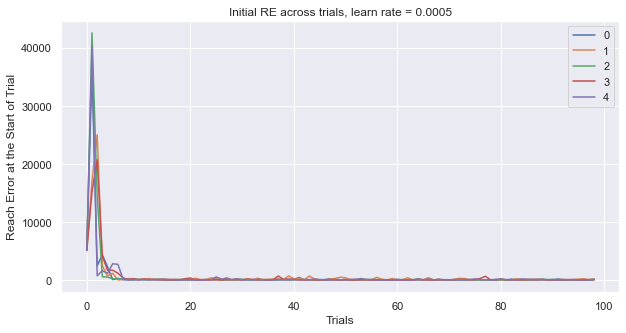

In [10]:
NUM_TRIALS = 100
NUM_RUNS = 2 # Has to be >1 # 2 = goes through the trial for target once
NUM_SESSIONS = 5
# rate_list = [5e-3, 1e-3, 5e-4, 1e-4]
rate_list = [5e-4]
A_RATE = 1e-4
K_RATE = 1e-4
ADAPT_TRIALS = NUM_TRIALS

# initialization
cursor_start = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
cursor_end = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
target_trial = np.zeros( (NUM_DIM, 1, NUM_TRIALS, NUM_SESSIONS) )
lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS, NUM_SESSIONS) )
fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
a_trial = np.zeros( (NUM_DIM, NUM_TRIALS, NUM_SESSIONS) )
k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS, NUM_SESSIONS) )
re_startT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )
re_endT = np.zeros( (NUM_TRIALS, NUM_SESSIONS) )


for lambda_rate in rate_list:
    for iS in range(NUM_SESSIONS):
        print("")
        print("+++++++++++++++++++++++++++++++++++")
        print("Session #" + str(iS))
        print("Adaptive Decoder = " + str(ADAPT_DEC))
        print("Adaptive Brain = " + str(BRAIN_ADAPT))
        ## BRAIN SIDE
        FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
    #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))

        ## DECODER SIDE
        A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
        K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)

        # target position -- new target represents a new trial
        target_trial[:, :, 0, iS] = TARGET_VECTOR
        print("target at trial 0 = " + str(target_trial[:, :, 0, iS]))

        print("K MATX INIT= " + str(K_MATX))
        print("A VECT INIT = " + str(A_VECT))

        ## VECTORS FOR TRIALS    
        lambda_trial[:, :, 0, iS] = lambda_init
        print("lambda")
        print(lambda_trial[:, :, 0, iS])

        a_trial[:, 0, iS] = np.array(A_VECT)
        print("a")
        print(a_trial[:, 0, iS])

        k_trial[:,:, 0, iS] = K_MATX
        print("K")
        print(k_trial[:,:, 0, iS] )
        decoder_params = (a_trial[:, 0, iS], A_RATE, A_DIST, k_trial[:,:,  0, iS], K_RATE, K_DIST)
        decoder_vals = (A_VECT, K_MATX)
        

        for iT in range(NUM_TRIALS-1):
            print("")
            print("=========================================")
            print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
            print("Target = " + str(target_trial[:, :, iT, iS]))

            # calculate firing rate given lambda and decoder parameters with current target position 
            fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT, iS], target_trial[:, :, iT, iS]))
            fr_trial[:, :, iT] = fr_start
            
#             print("lambda start of trial = " + str(lambda_trial[:, :, iT, iS]))
            # calculate reach error of firing rate at the beginning of the trial
            # this becomes the error of the new target position being presented and where the cursor is
            brain_vars = ( fr_trial[:, :, iT],  target_trial[:, :, iT, iS] )
            cost_func_params = (decoder_vals, brain_vars) 
            
            re_startT[iT, iS] = error_costFunc(cost_func_params)

    #         (a_vect_in, k_matx_in) = decoder_params
            cursor_start[ :, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
            print("cursor start = " + str(cursor_start[:, :, iT, iS]) )
            print("decoder vals start = " + str(decoder_vals))

            # Run through trial and see the reach at the end        
            # current brain and decoder params
            brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT, iS], lambda_rate)
            decoder_params = (a_trial[:, iT, iS], A_RATE, A_DIST, k_trial[:, :,  iT, iS], K_RATE, K_DIST)

            # adapt brain and decoder (together here)
            a_run, k_run = calcNextDecoder(decoder_params, brain_vars)
            if (KW_only):
                a_run = np.zeros((2, 1))
                
            if (BRAIN_ADAPT):
                fr_run, lambda_run = calcNextBrain(brain_params, decoder_params, target_trial[:, :, iT, iS], NUM_RUNS)
            else:
                fr_run = fr_trial[:, :, iT]
                lambda_run = lambda_trial[:, :, iT, iS]
            
            # update cost function arguments
            decoder_vals = (a_run, k_run)
            brain_vars = (fr_run, target_trial[:, :, iT, iS])
            # see how the updated decoder and brain paramters have done with the current
            # target position (so target at trial = iT)
            cost_func_params = (decoder_vals, brain_vars) 
            re_run = np.array(error_costFunc(cost_func_params))

            # So what are the end trial metrics?
            if (KW_only):
                lambda_run[:, 0] = 0
            cursor_end[:, :, iT, iS] =  (decoder_findY(decoder_vals, brain_vars))
            print("fr end of trial = " + str(fr_run))
            print("lambda end of trial = " + str(lambda_run))
            print("cursor end = " + str(cursor_end[:, :, iT, iS]) )

            re_endT[iT, iS] = re_run
#             print("re end = " + str(re_endT[iT, iS]))
#             print("re diff = " + str(re_endT[iT, iS] - re_startT[iT, iS]))

            # update the parameters
            lambda_trial[:, :, iT + 1, iS] = np.squeeze(lambda_run)
        
            a_trial[:, iT + 1, iS] = np.squeeze(a_run)
            k_trial[:, :, iT + 1, iS] = np.squeeze(k_run)
            print("a = " + str(a_trial[:, iT + 1, iS]))
            print("k = " + str(k_trial[:, :, iT + 1, iS]))

            # change to new target
            target_trial[:, 0, iT + 1, iS] = findNextTarget( cursor_end[:, :, iT, iS], target_trial[:, :, iT, iS] )
    
        
        pidx = rate_list.index(lambda_rate)
        plt.figure(2*pidx + 1, figsize=(fig_x, fig_y))
        plt.plot(np.arange(0, NUM_TRIALS-1, 1), re_startT[0:len(re_startT)-1, iS], label = '' + str(iS))
        plt.legend()
        plt.xlabel('Trials')
        plt.ylabel('Reach Error at the Start of Trial')
        plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate))

    

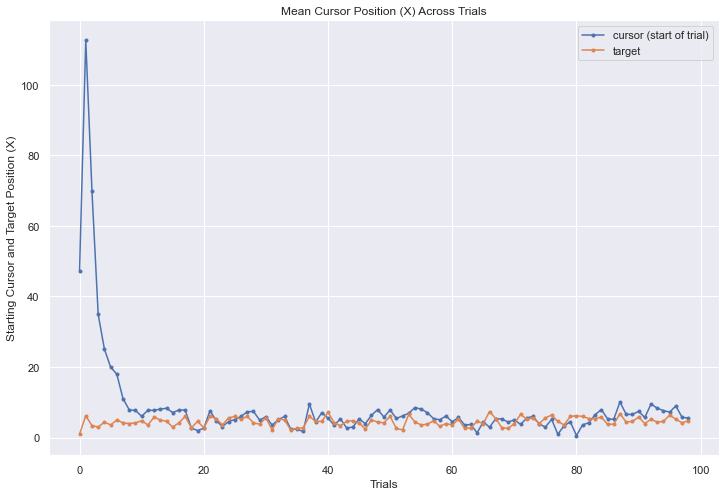

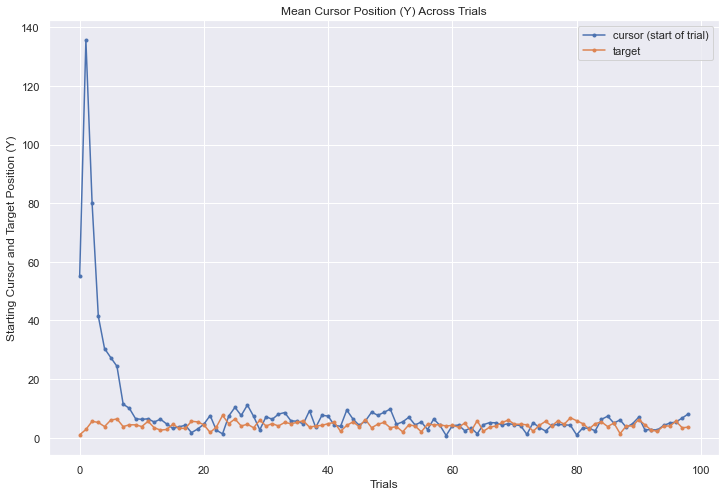

In [11]:
x = 0
y = 1

plt.figure(figsize = (12, 8))
start_x_mean = np.mean(cursor_start, axis=3)[x, 0, 0:NUM_TRIALS-1]
end_x_mean = np.mean(cursor_end, axis=3)[x, 0, 0:NUM_TRIALS-1]
start_y_mean = np.mean(cursor_start, axis=3)[y, 0, 0:NUM_TRIALS-1]
end_y_mean = np.mean(cursor_end, axis=3)[y, 0, 0:NUM_TRIALS-1]
targ_x_mean = np.mean(target_trial, axis=3)[x, 0, 0:NUM_TRIALS-1]
targ_y_mean = np.mean(target_trial, axis=3)[y, 0, 0:NUM_TRIALS-1]

plt.plot(start_x_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (X)')
plt.title('Mean Cursor Position (X) Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_x_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_x_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (X)')
# plt.title('Cursor Position Across Trials')
# plt.show()

plt.figure(figsize = (12, 8))
plt.plot(start_y_mean, linestyle = '-', marker = '.', label = 'cursor (start of trial)')
plt.plot(targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Starting Cursor and Target Position (Y)')
plt.title('Mean Cursor Position (Y) Across Trials')
plt.show()

# plt.figure(figsize = (12, 8))
# plt.plot(np.arange(0, NUM_TRIALS, 1), end_y_mean, linestyle = '-', marker = '.', label = 'cursor (end of trial)')
# plt.plot(np.arange(0, NUM_TRIALS, 1), targ_y_mean, linestyle = '-', marker = '.', label = 'target' )
# plt.legend()
# plt.xlabel('Trials')
# plt.ylabel('Ending Cursor and Target Position (Y)')
# plt.title('Cursor Position Across Trials')
# plt.show()

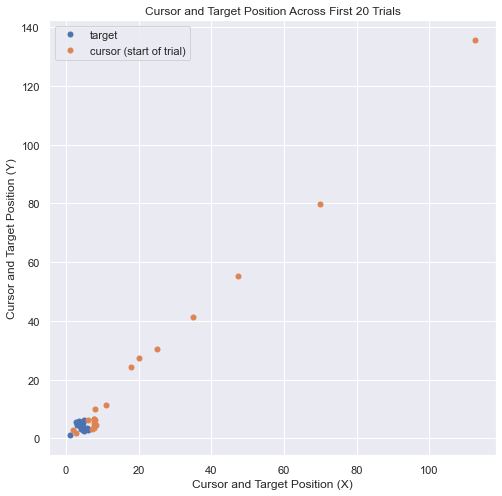

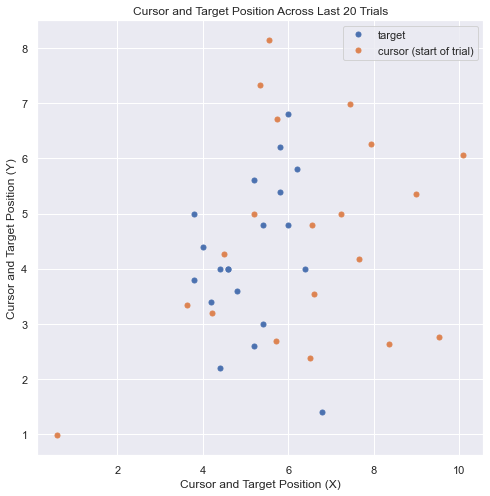

In [12]:
show_num = 20
plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[0:show_num], targ_y_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[0:show_num], start_y_mean[0:show_num], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across First 20 Trials')
plt.show()

plt.figure(figsize = (8, 8))
plt.plot(targ_x_mean[-show_num:], targ_y_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'target' )
plt.plot(start_x_mean[-show_num:], start_y_mean[-show_num:], linestyle = '', marker = '.', markersize = 10, label = 'cursor (start of trial)')
plt.legend()
plt.xlabel('Cursor and Target Position (X)')
plt.ylabel('Cursor and Target Position (Y)')
plt.title('Cursor and Target Position Across Last 20 Trials')
plt.show()


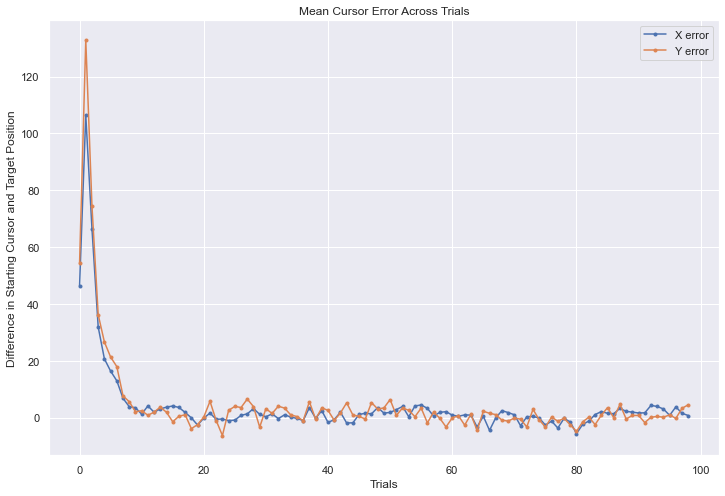

In [13]:
plt.figure(figsize = (12, 8))
plt.plot(start_x_mean - targ_x_mean, linestyle = '-', marker = '.', label = 'X error')
plt.plot(start_y_mean - targ_y_mean, linestyle = '-', marker = '.', label = 'Y error' )
plt.legend()
plt.xlabel('Trials')
plt.ylabel('Difference in Starting Cursor and Target Position')
plt.title('Mean Cursor Error Across Trials')
plt.show()

Text(0.5, 1.0, 'Mean KW Matrix (1,1)')

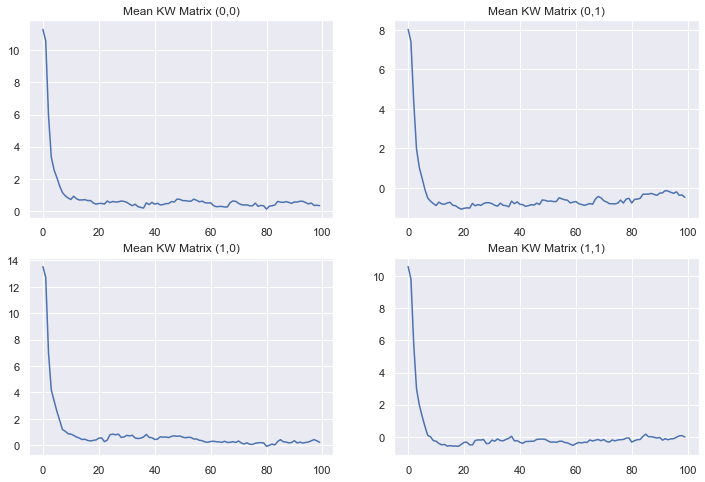

In [14]:
# print(np.shape(lambda_trial))
# print(np.shape(k_trial))
# print(np.shape((k_trial[:, :,1])))
# print(np.shape((lambda_trial[:, 1:3, 1])))

lk_mtx = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS))
lk_mtx_temp = np.zeros((NUM_DIM, NUM_DIM, NUM_TRIALS, NUM_SESSIONS))
# print(np.shape((k_trial[:,:, :, 1])))
# print((lambda_trial[:, 1:3, 1, 1]))
for iT in range(NUM_TRIALS):
    for iS in range(NUM_SESSIONS):
        lk_mtx_temp[:,:, iT, iS] = np.matmul(k_trial[:,:, iT, iS], lambda_trial[:, 1:3, iT, iS])
    lk_mtx = np.mean(lk_mtx_temp[:,:, :, :], axis=3)

 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, :])
plt.title("Mean KW Matrix (0,0)")

plt.subplot(222)
plt.plot(lk_mtx[0, 1, :])
plt.title("Mean KW Matrix (0,1)")

plt.subplot(223)
plt.plot(lk_mtx[1, 0, :])
plt.title("Mean KW Matrix (1,0)")

plt.subplot(224)
plt.plot(lk_mtx[1, 1, :])
plt.title("Mean KW Matrix (1,1)")


Text(0.5, 1.0, 'Mean KW Matrix (1,1) | Last 100 Trials ')

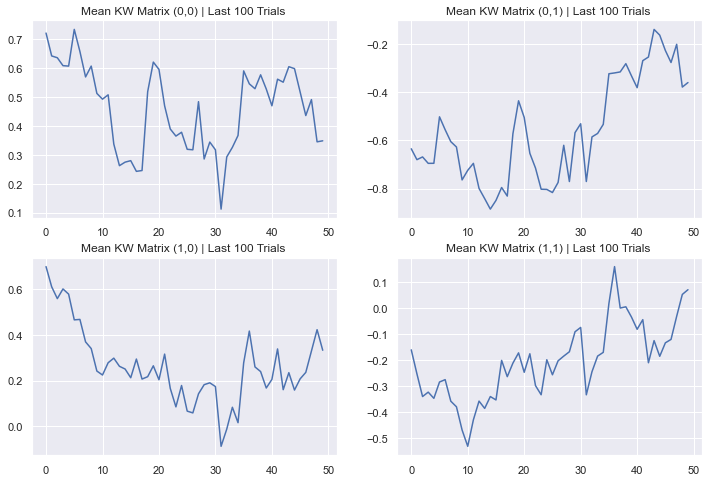

In [15]:
last = 50

plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.plot(lk_mtx[0, 0, NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,0) | Last 100 Trials ")

plt.subplot(222)
plt.plot(lk_mtx[0, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (0,1) | Last 100 Trials ")


plt.subplot(223)
plt.plot(lk_mtx[1, 0,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,0) | Last 100 Trials ")

plt.subplot(224)
plt.plot(lk_mtx[1, 1,  NUM_TRIALS-1-last:NUM_TRIALS-1])
plt.title("Mean KW Matrix (1,1) | Last 100 Trials ")


In [16]:
print("Average Reach Error Per Session:")

for iS in range(NUM_SESSIONS):
    print("Session # " + str(iS) + "| RE = " + str(np.mean(re_startT[:, iS])))

Average Reach Error Per Session:
Session # 0| RE = 553.8483007038511
Session # 1| RE = 636.9984954901051
Session # 2| RE = 668.3912277242775
Session # 3| RE = 553.6787448293145
Session # 4| RE = 598.9441822246728


In [17]:
# TODO Here:
# print the K matrix across time
# print lambda matrix across time for quick check of adapting


print(np.shape((k_trial)))
print(np.shape(lambda_trial))


(2, 10, 100, 5)
(10, 3, 100, 5)


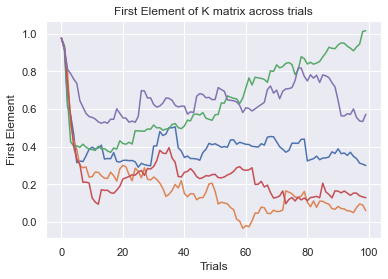

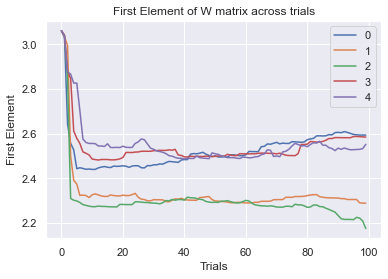

In [18]:
# plot of 1st dimension, neuron #1 and 1st session 

for iS in range(NUM_SESSIONS):
    plt.plot(k_trial[1, 1,:, iS], label=''+str(iS))
plt.title("First Element of K matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.show()

for iS in range(NUM_SESSIONS):
    plt.plot(lambda_trial[1, 2,:, iS], label=''+str(iS))
plt.title("First Element of W matrix across trials")
plt.xlabel("Trials")
plt.ylabel("First Element")
plt.legend()